In [1]:
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from scipy import stats
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import MinMaxScaler, StandardScaler

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Prepare pheno data

In [2]:
qc = pandas.ExcelFile('/Users/jacobv/Science/PLS_GXP/XSpecies/Dev/mRNA-seq_QC.xlsx'
                     ).parse('Sheet1',header=2)
qc.head()

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  """Entry point for launching an IPython kernel.


,Sample,Species,Brain,Sex,Region,NCXRegion,Age,Days,Period,Predicted age (PC Days),Predicted period,Sequencing site,RNA extraction,Platform,RIN,Total reads,Uniquely mapped reads,Multiple reads,Uniquely mapped to ChrM
0,RMB209.AMY,Macaque,RMB209,F,AMY,AMY,E60,60.0,NaN,101.874504,4,YALE,mirVana,HiSeq,8.7,20059352,16691828,1570243,73081
1,RMB209.CBC,Macaque,RMB209,F,CBC,CBC,E60,60.0,NaN,101.874504,4,YALE,mirVana,HiSeq,8.8,24337153,20448575,1628906,105528
2,RMB209.HIP,Macaque,RMB209,F,HIP,HIP,E60,60.0,NaN,101.874504,4,YALE,mirVana,HiSeq,9.0,22992437,19436947,1650765,78079
3,RMB209.MD,Macaque,RMB209,F,MD,MD,E60,60.0,NaN,101.874504,4,YALE,mirVana,HiSeq,9.0,14859176,12163190,1018555,45757
4,RMB209.DFC,Macaque,RMB209,F,DFC,NCX,E60,60.0,NaN,101.874504,4,YALE,mirVana,HiSeq,8.1,26085236,20635706,3083884,146178


In [3]:
qc.Age.unique()

array(['E60', 'E81', 'E82', 'E80', 'E111', 'E110', 'P2', 'P0', '1Y', '7M',
       '2Y', '4Y', '7Y', '5Y', '11Y', '3.5Y', '8 PCW', '9 PCW', '12 PCW',
       '13 PCW', '16 PCW', '17 PCW', '19 PCW', '21 PCW', '22 PCW',
       '37 PCW', '4 M', '10 M', '1 Y', '3 Y', '4 Y', '8 Y', '11 Y',
       '13 Y', '15 Y', '19 Y', '21 Y', '23 Y', '30 Y', '36 Y', '37 Y',
       '40 Y'], dtype=object)

In [4]:
60/7

8.571428571428571

In [5]:
horder = ['8 PCW', '9 PCW', '12 PCW', '13 PCW', '16 PCW', '17 PCW', '19 PCW',
       '21 PCW', '22 PCW', '37 PCW', '4 M', '10 M', '1 Y', '3 Y', '4 Y',
       '8 Y', '11 Y', '13 Y', '15 Y', '19 Y', '21 Y', '23 Y', '30 Y',
       '36 Y', '37 Y', '40 Y']
morder = ['E60', 'E81', 'E82', 'E80', 'E111', 'E110', 'P0','P2', '7M','1Y',
       '2Y', '3.5Y', '4Y', '5Y','7Y', '11Y',]

# stage
fetal = ['8 PCW', '9 PCW', '12 PCW', '13 PCW', '16 PCW', '17 PCW', '19 PCW',
       '21 PCW', '22 PCW', '37 PCW','E60', 'E81', 'E82', 'E80', 'E111', 'E110',]
infant = ['4 M', '10 M', '1 Y','P0','P2','7M','1Y']
child = ['3 Y', '4 Y','8 Y','2Y']
adolescent = ['11 Y', '13 Y', '15 Y', '19 Y','3.5Y', '4Y', '5Y','7Y',]
adult = ['21 Y', '23 Y', '30 Y','36 Y', '37 Y', '40 Y','11Y',]
divs = [fetal,infant,child,adolescent,adult]
names = ['fetal','infant','child','adolescent','adult']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    qc.loc[qc[qc.Age.isin(div)].index,'Age_Stage'] = name


mapper = {'Sensorimotor': ['S1C','M1C','MSC'],
          'Limbic': ['HIP','AMY'],
          'Cerebellum': ['CBC','URL'],
          'Striatum': ['STR'],
          'Frontal': ['OFC','VFC','DFC','MFC'],
          'Temporal': ['STC','A1C','ITC','TC'],
          'Parietal': ['IPC','PC',],
          'Occipital': ['V1C','OC'],
          'Thalamus': ['MD','DTH'],
          'Transient': ['LGE','MGE','CGE'],
         }
for name, div in mapper.items():
    qc.loc[qc[qc.Region.isin(div)].index,'MacroStructure'] = name


In [6]:
166/7

23.714285714285715

In [7]:
for i,row in qc.iterrows():
    age = row['Age']
    if age in horder:
        num,measure = age.split(' ')
        if measure == 'PCW':
            fage = int(num)
        elif measure == 'Y':
            fage = (int(num) * 52) + 39.105
        else:
            fage = (int(num) * 4.345) + 39.105
    elif age in morder:
        if 'E' in age:
            fage = int(age.split('E')[1]) / 7
        elif 'P' in age:
            fage = (166 + int(age.split('P')[1])) / 7
        elif 'M' in age:
            fage = (int(age.split('M')[0]) * 4.345) + 23.71
        else:
            fage = (float(age.split('Y')[0]) * 52) + 23.71
    qc.loc[i,'age_in_weeks'] = fage

In [8]:
166/7

23.714285714285715

In [9]:
qc.loc[:,'age_weeks'] = qc.Days.values / 7
#qc.loc[:,'log_age_weeks'] = np.log(qc.age_weeks.values)
qc.loc[:,'log_age_weeks'] = np.log(qc.age_in_weeks.values)

In [10]:
hcode = dict(zip(horder,range(len(horder))))
mcode = dict(zip(morder,range(len(morder))))
for i,row in qc.iterrows():
    age = row['Age']
    if age in horder:
        qc.loc[i,'age_level'] = hcode[age]
    elif age in morder:
        qc.loc[i,'age_level'] = mcode[age]
    else:
        print(age,'not found')

# Get components

In [35]:
df = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/XSpecies/Dev/nhp_development_RPKM_rmTechRep.txt',
                      sep='\t')
df.loc[:,'future_ind'] = [x.split('|')[-1] for x in df.index.values]
df.index = range(len(df))
print(df.shape)

(27932, 827)


In [36]:
dups = []
dind = []
catch = []
for i,row in df.iterrows():
    x = row['future_ind']
    if x in catch: 
        dups.append(x)
        dind.append(i)
    else:
        catch.append(x)

In [40]:
df.drop(dind,inplace=True)
df.index = df.future_ind.values
df.drop('future_ind',axis=1,inplace=True)

In [41]:
allcomps = pandas.read_csv('./tables/all_comps_ROTATION.csv',index_col=0)
allcomps.index = allcomps.gene_symbol.values
allcomps.head()
shared = set(df.index.values) & set(allcomps.index)
df = df.loc[shared]

In [44]:
# Generated in NB1
hbigdf = pandas.read_csv('data/expression.csv') 
allendir = '/Users/jacobv/abagen-data/microarray/'
probes = pandas.read_csv(os.path.join(allendir,'normalized_microarray_donor10021/Probes.csv'))
# Generated in NB2
hgdf = pandas.read_csv('data/PLS_GXp_gdf.csv',index_col=0) # Generated in NB2
hbigdf.index = hgdf.index
hbigdf.drop('well_id',axis=1,inplace=True)

In [45]:
hbigdf = hbigdf[df.index]

In [46]:
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

# recover the PCA results
pcamod = PCA(n_components=100, random_state=123).fit(hbigdf)
pca_tfm = pandas.DataFrame(pcamod.transform(hbigdf),index = hgdf.index)

In [47]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error

full_y = hgdf[['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
pls_mod = PLSRegression(n_components=3)
pred = cross_val_predict(pls_mod,pca_tfm,full_y,cv=10)
#sns.regplot(pred,full_y)
print('r2_score =',r2_score(full_y,pred))
print('mae =',mean_absolute_error(full_y,pred))

r2_score = 0.5299147796678715
mae = 14.433875691177512


In [48]:
full_y = hgdf[['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(pca_tfm, full_y)

PLSRegression(n_components=3)

In [49]:
df.shape

(13087, 826)

In [50]:
hbigdf.shape

(3466, 13087)

In [51]:
# Minmax
adulthuman = df[qc[(qc.Species=='Human') & (qc.Age_Stage=='adult')].Sample.values]
mmmod = MinMaxScaler().fit(adulthuman.T)
hb_pcatfm = pcamod.transform(mmmod.transform(df[qc.Sample.values].T))
xtfm = pls_mod.transform(hb_pcatfm)

In [52]:
for i in range(3):
    qc.loc[:,'C%s_exp'%(i+1)] = xtfm[:,i]

# Validate

In [53]:
abac2 = pandas.read_csv('data/GCorr_BSComp_ABA_C2_data_ROTATION.csv',
                       index_col=0)
abac2.columns = ['ABA_mean','ABA_sem']
print('shared:',set(abac2.index) & set(qc.MacroStructure.unique()))
print('missing:',set(qc.MacroStructure.unique()) - set(abac2.index))

bsc2 = pandas.pivot_table(#qc,
                            qc[(qc.Age_Stage=='adult') & (qc.Species=='Human')],
                          values='C2_exp',
                             index='MacroStructure',aggfunc=np.mean
                            )
for div in bsc2.index:
    sem = qc[(qc.Age_Stage=='adult') & (qc.Species=='Human') & (qc.MacroStructure==div)
            ]['C2_exp'].sem()
    bsc2.loc[div,'sem'] = sem
bsc2.columns = ['BS_mean','BS_sem']

c2_comp = pandas.concat([bsc2,abac2],axis=1,sort='True').dropna()
c2_comp.loc[:,'region'] = c2_comp.index
c2_comp.head()

shared: {'Occipital', 'Parietal', 'Striatum', 'Thalamus', 'Frontal', 'Limbic', 'Cerebellum', 'Temporal', 'Sensorimotor'}
missing: {'Transient'}


,BS_mean,BS_sem,ABA_mean,ABA_sem,region
Cerebellum,-0.271709,0.086946,-0.706893,0.019982,Cerebellum
Frontal,0.573367,0.167683,0.789432,0.031165,Frontal
Limbic,0.565131,0.128855,0.030956,0.039398,Limbic
Occipital,-1.079097,0.219612,-1.655174,0.042085,Occipital
Parietal,-0.631850,0.194580,-1.124981,0.031968,Parietal


In [54]:
n_comps = 3
for i in range(1,(n_comps+1)):
    vals = StandardScaler().fit_transform(qc.loc[:,'C%s_exp'%i
                                                 ].values.reshape(-1,1)
                                         )[:,0]
    qc.loc[:,'zC%s_exp'%i,] = vals

r = 0.977, p = 0.0


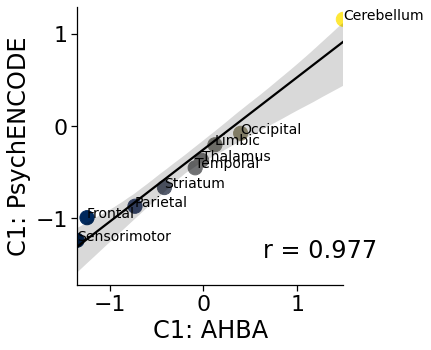

r = 0.964, p = 0.0


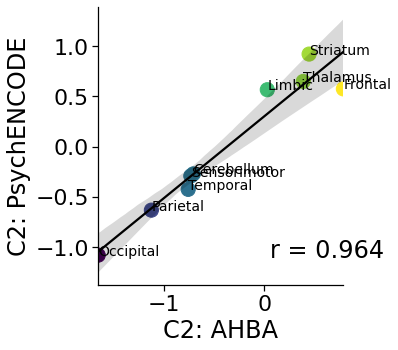

r = 0.901, p = 0.001


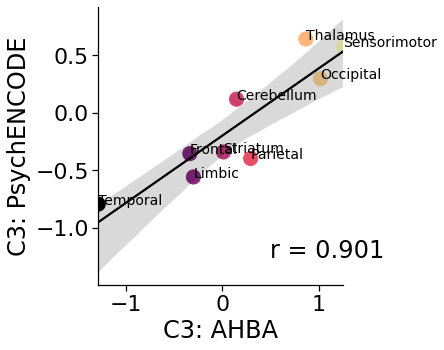

In [55]:
# note this analysis is only performed on the adult brainspan samples
sns.set_context('notebook',font_scale=2)
pals = ['cividis','viridis','magma']
for i in range(1,(n_comps+1)):
    # read allen data
    aba = pandas.read_csv('data/GCorr_BSComp_ABA_C%s_data_ROTATION.csv'%i,
                       index_col=0)
    aba.columns = ['ABA_mean','ABA_sem']
    # prep brainspan data
    bs = pandas.pivot_table(#gdf,
                            qc[(qc.Age_Stage=='adult') & (qc.Species=='Human')],# just the human adultss!
                          values='C%s_exp'%i,
                             index='MacroStructure',aggfunc=np.mean
                            )
    # calculate SEM (I don't think i actually use this)
    for div in bs.index:
        sem = qc[(qc.Age_Stage=='adult') & (qc.Species=='Human') & (qc.MacroStructure==div)
                 ]['C%s_exp'%i].sem()
        bs.loc[div,'sem'] = sem
    bs.columns = ['PEC_mean','PEC_sem']
    # build comparison dataframe
    comp = pandas.concat([bs,aba],axis=1,sort='True').dropna()
    comp.loc[:,'region'] = c2_comp.index
    
    # colors
    cmap = sns.color_palette(pals[i-1],as_cmap=True)
    sg = comp.ABA_mean.values
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))
    
    # plot
    g=sns.lmplot(x='ABA_mean',y='PEC_mean',data=comp,
           scatter_kws={'marker':'o','s':200,'color':cscale},
               line_kws={'color':'k'}
          )
    # stats
    r,p = stats.pearsonr(comp.ABA_mean.values,comp.PEC_mean.values)
    print('r = %s, p = %s'%(round(r,3),round(p,3)))
    # decorate
    for it,div in enumerate(comp.sort_values('ABA_mean').index):
        x = comp.loc[div,'ABA_mean']
        y = comp.loc[div,'PEC_mean']
        dist = len(div)*.02
        if it%2==0:
            plt.text(x, y,div,{'size':14})
        else:
            plt.text(x, y,div,{'size':14},
                     )
    plt.xlabel('C%s: AHBA'%i)
    plt.ylabel('C%s: PsychENCODE'%i)
    plt.text(0.7,0.1,'r = %s'%round(r,3),transform=g.ax.transAxes)
    #plt.xlim(-.45,.45)
    #plt.savefig(os.path.join(figdir,'PsyENC_Repl_C%s_ROTATED.pdf'%i), bbox_inches='tight')
    plt.show()

# Validate human development

In [56]:
qc.head()

,Sample,Species,Brain,Sex,Region,NCXRegion,Age,Days,Period,Predicted age (PC Days),...,age_in_weeks,age_weeks,log_age_weeks,age_level,C1_exp,C2_exp,C3_exp,zC1_exp,zC2_exp,zC3_exp
0,RMB209.AMY,Macaque,RMB209,F,AMY,AMY,E60,60.0,NaN,101.874504,...,8.571429,8.571429,2.148434,0.0,1.024033,2.072037,-0.666254,1.082002,0.292514,0.170834
1,RMB209.CBC,Macaque,RMB209,F,CBC,CBC,E60,60.0,NaN,101.874504,...,8.571429,8.571429,2.148434,0.0,1.835942,1.772492,-1.023053,2.069919,0.076373,-0.300357
2,RMB209.HIP,Macaque,RMB209,F,HIP,HIP,E60,60.0,NaN,101.874504,...,8.571429,8.571429,2.148434,0.0,0.752191,2.271584,0.269697,0.751228,0.436500,1.406857
3,RMB209.MD,Macaque,RMB209,F,MD,MD,E60,60.0,NaN,101.874504,...,8.571429,8.571429,2.148434,0.0,0.771614,2.454671,-1.159481,0.774862,0.568608,-0.480525
4,RMB209.DFC,Macaque,RMB209,F,DFC,NCX,E60,60.0,NaN,101.874504,...,8.571429,8.571429,2.148434,0.0,0.737083,2.717826,-0.339376,0.732846,0.758492,0.602510


In [57]:
# create individual dfs for each component
gpdfs = {}
for i in range(1,(n_comps+1)):
    gpdf = qc[['Brain','C%s_exp'%i,'MacroStructure']
                  ].set_index(['Brain'],append=True
                             ).pivot_table(index='Brain',
                                           columns='MacroStructure',
                                           values='C%s_exp'%i)
    gpdf.drop('Transient',axis=1,inplace=True)
    for ind,row in gpdf.iterrows():
        n_valid = len([x for x in row.values if pandas.notnull(x)])
        gpdf.loc[ind,'n_valid'] = n_valid
    gpdfs.update({i: gpdf})

In [58]:
# now we'll create similarity calculations for each subject, for each component.
# we'll only use subjects that have data for 6+ brain regions

# for each component
for c in range(1,(n_comps+1)):
    # prep data
    cdf = gpdfs[c]
    aba = pandas.read_csv('data/GCorr_BSComp_ABA_C%s_data_ROTATION.csv'%c,
                       index_col=0)
    aba.columns = ['ABA_mean','ABA_sem']
    aba = aba.loc[cdf.columns[:-1]]
    # for each subject
    for i,row in cdf.iterrows():
        forcorr = pandas.DataFrame(aba,copy=True)
        # if subject has 6+ regions with data
        if row['n_valid'] > 5:
            # find similarity to Allen expression
            forcorr.loc[:,'gvec'] = row.values[:-1]
            forcorr.dropna(inplace=True)
            r = stats.pearsonr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            rho = stats.spearmanr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            # store values
            cdf.loc[i,'C%s_r'%c] = r
            cdf.loc[i,'C%s_rho'%c] = rho

In [59]:
qc.columns

Index(['Sample', 'Species', 'Brain', 'Sex', 'Region', 'NCXRegion', 'Age',
       'Days', 'Period', 'Predicted age (PC Days)', 'Predicted period',
       'Sequencing site', 'RNA extraction', 'Platform', 'RIN', 'Total reads',
       'Uniquely mapped reads', 'Multiple reads', 'Uniquely mapped to ChrM',
       'Age_Stage', 'MacroStructure', 'age_in_weeks', 'age_weeks',
       'log_age_weeks', 'age_level', 'C1_exp', 'C2_exp', 'C3_exp', 'zC1_exp',
       'zC2_exp', 'zC3_exp'],
      dtype='object')

In [60]:
gpdfs[1].index

Index(['HSB103', 'HSB107', 'HSB112', 'HSB113', 'HSB114', 'HSB118', 'HSB119',
       'HSB122', 'HSB123', 'HSB124', 'HSB126', 'HSB127', 'HSB130', 'HSB132',
       'HSB135', 'HSB136', 'HSB139', 'HSB141', 'HSB145', 'HSB148', 'HSB149',
       'HSB150', 'HSB153', 'HSB154', 'HSB159', 'HSB171', 'HSB172', 'HSB173',
       'HSB174', 'HSB175', 'HSB178', 'HSB194', 'HSB92', 'HSB96', 'HSB97',
       'HSB98', 'RMB160', 'RMB161', 'RMB177R', 'RMB188L', 'RMB193L', 'RMB196',
       'RMB199L', 'RMB200L', 'RMB201L', 'RMB202', 'RMB207', 'RMB208', 'RMB209',
       'RMB212', 'RMB213', 'RMB214', 'RMB215', 'RMB216', 'RMB217', 'RMB218',
       'RMB219', 'RMB227', 'RMB228', 'RMB233', 'RMB291', 'RMB296'],
      dtype='object', name='Brain')

In [61]:
# build a summary dataframe at the indexed by subjects

cols = ['Sample', 'Species', 'Brain', 'Sex', 'Region', 'NCXRegion', 'Age',
       'Days', 'Period', 'Predicted age (PC Days)', 'Predicted period',
       'Sequencing site', 'RNA extraction', 'Platform', 'RIN', 'Total reads',
       'Uniquely mapped reads', 'Multiple reads', 'Uniquely mapped to ChrM',
       'Age_Stage', 'MacroStructure', 'age_weeks', 'log_age_weeks','age_level']
subsum = pandas.DataFrame(gpdfs[1].index)
for col in cols:
    subsum.loc[:,col] = qc.groupby('Brain')[col].first().loc[gpdfs[1].index].values
for c in range(1,(n_comps+1)):
    subsum.loc[:,'C%s_r'%c] = gpdfs[c].loc[:,'C%s_r'%c].values
    subsum.loc[:,'C%s_rho'%c] = gpdfs[c].loc[:,'C%s_rho'%c].values
    subsum.loc[:,'n_valid'] = gpdfs[c].loc[:,'n_valid'].values

In [62]:
fig_dir = '/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/Manuscript/Figs/PostFix/subfigs/'

>>>>>>>> Macaque <<<<<<<<
r=0.469, p=0.0209


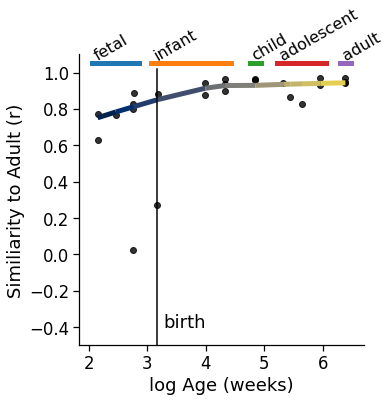

r=0.79, p=0.0


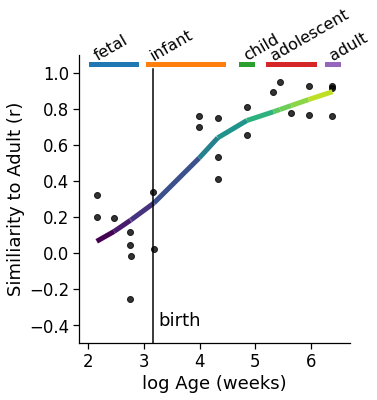

r=0.768, p=0.0


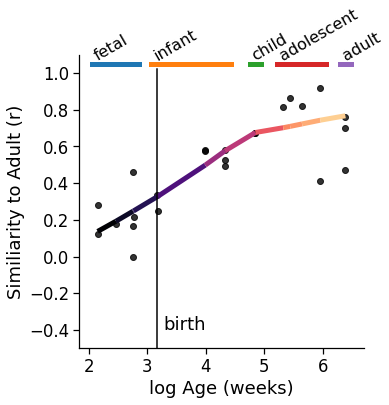

>>>>>>>> Human <<<<<<<<
r=0.636, p=0.0001


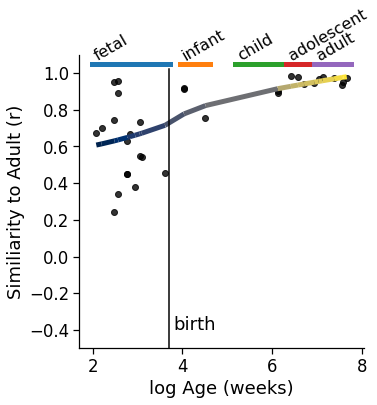

r=0.784, p=0.0


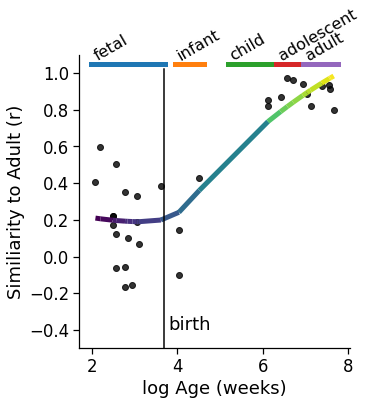

r=0.681, p=0.0


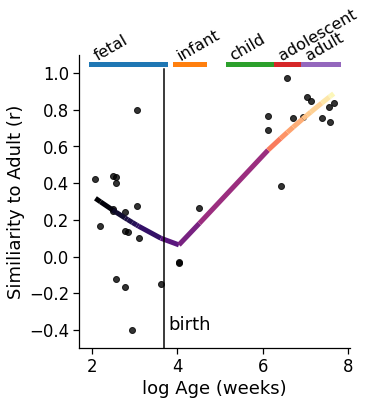

In [63]:
# plot similarity to Allen Brain (i.e. adult data) against age for each component 

for species in qc.Species.unique():
    print('>'*8,species,'<'*8)
    sns.set_context('notebook',font_scale=1.5)
    # for each component
    for c in range(1,(n_comps+1)):
        # plot
        g=sns.lmplot(x='log_age_weeks',y='C%s_r'%c,
                    lowess=True,
                     scatter_kws={'color':'k'},
                   data=subsum[subsum.Species==species])
        plotr = pandas.DataFrame(subsum[subsum.Species==species][['C%s_r'%c,'age_level']],
                                copy=True).dropna()
        # get stats
        r,p=stats.pearsonr(plotr['C%s_r'%c].values,
                          plotr.age_level.values)
        print('r=%s, p=%s'%(round(r,3),round(p,4)))

        # make line purty
        x, y = g.ax.get_lines()[0].get_data()
        segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
        norm = plt.Normalize(x.min(), x.max())
        lc = LineCollection(segments, cmap=pals[c-1], norm=norm)
        lc.set_array(x[:-1])
        lc.set_linewidth(2)
        g.ax.get_lines()[0].remove()
        line = g.ax.add_collection(lc)
        plt.setp(line,linewidth=5)

        # decorate so age stage is indicated
        for stage in qc[qc.Species==species].Age_Stage.unique():
            levels = qc[(qc.Age_Stage==stage) & (qc.Species==species)]['log_age_weeks'].values
            xmin = np.min(levels) -0.1
            xmax = np.max(levels) +0.1
            plt.plot([xmin,xmax],[1.05,1.05],lw=5)
            #loc = xmin + (xmax-xmin)*.5
            plt.text(xmin,1.05,stage,fontsize=16,ha='left',
                     va='bottom',rotation=30)
        # further decorate
        plt.ylabel('Similiarity to Adult (r)')
        plt.xlabel('log Age (weeks)',)#fontsize=30)
        plt.ylim(-0.5,1.1)
        ymin = subsum['C%s_r'%c].min() - 0.1
        if species == 'Human':
            plt.axvline(np.log(40),ymax=0.95,c='k')
            plt.text(np.log(40)+0.1,-0.4,'birth')
        else:
            plt.axvline(np.log(23.714),ymax=0.95,c='k')
            plt.text(np.log(23.714)+0.1,-0.4,'birth')
#         plt.savefig(os.path.join(fig_dir,'PEC_%s_CompR_C%s.pdf'%(species,c)), 
#                                  bbox_inches='tight')
        plt.show()
    

In [64]:
# Let's plot all those lines on one plot

devplot = pandas.DataFrame(pandas.concat([subsum.C1_r,
                                          subsum.C2_r,
                                          subsum.C3_r]))
devplot.columns = ['r']
n = len(subsum)
devplot.loc[:,'Component'] = ['1']*n + ['2']*n + ['3']*n
devplot.loc[:,'age_level'] = subsum.age_level.tolist() * 3
devplot.loc[:,'age_stage'] = subsum.Age_Stage.tolist() * 3
devplot.loc[:,'age_weeks'] = subsum.age_weeks.tolist() * 3
devplot.loc[:,'log_age_weeks'] = subsum.log_age_weeks.tolist() * 3
devplot.loc[:,'Species'] = subsum.Species.tolist() * 3

In [65]:
qc[qc.Species=='Macaque'].Age_Stage.unique()

array(['fetal', 'infant', 'child', 'adolescent', 'adult'], dtype=object)

In [66]:
subsum.columns

Index(['Brain', 'Sample', 'Species', 'Sex', 'Region', 'NCXRegion', 'Age',
       'Days', 'Period', 'Predicted age (PC Days)', 'Predicted period',
       'Sequencing site', 'RNA extraction', 'Platform', 'RIN', 'Total reads',
       'Uniquely mapped reads', 'Multiple reads', 'Uniquely mapped to ChrM',
       'Age_Stage', 'MacroStructure', 'age_weeks', 'log_age_weeks',
       'age_level', 'C1_r', 'C1_rho', 'n_valid', 'C2_r', 'C2_rho', 'C3_r',
       'C3_rho'],
      dtype='object')

In [67]:
subsum[subsum.Species=='Macaque'].Sex.value_counts()

M    18
F     8
Name: Sex, dtype: int64

In [68]:
len(subsum)

62

In [224]:
qc.Region.value_counts()

VFC    55
OFC    54
IPC    54
MFC    54
A1C    52
DFC    51
V1C    51
STC    51
HIP    50
ITC    49
CBC    49
M1C    49
S1C    48
MD     47
AMY    46
STR    45
MSC     6
DTH     2
OC      2
CGE     2
MGE     2
URL     2
LGE     2
PC      2
TC      1
Name: Region, dtype: int64

>>>>>>>> Macaque <<<<<<<<


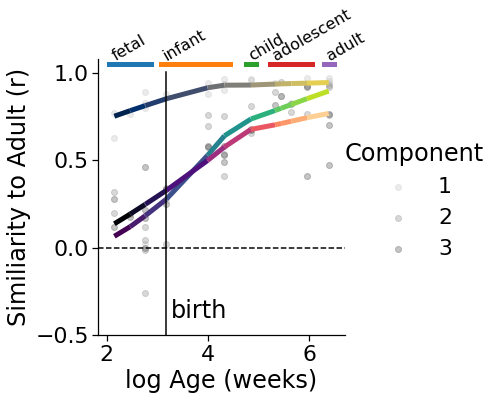

>>>>>>>> Human <<<<<<<<


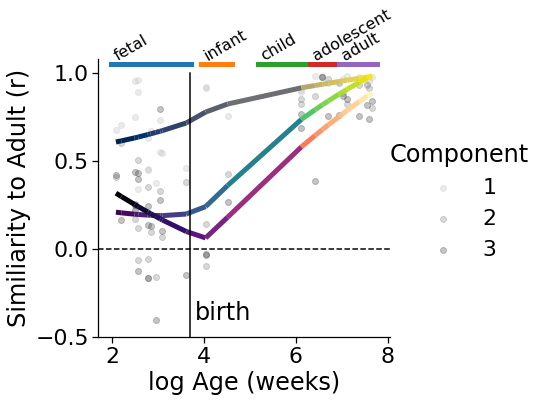

In [69]:
sns.set_context('notebook',font_scale=2)
for species in qc.Species.unique():
    print('>'*8,species,'<'*8)
    g=sns.lmplot(x='log_age_weeks',y='r',hue='Component',lowess=True,aspect=1.1,
                 hue_order=['1','2','3'],palette='binary',
                   data=devplot[devplot.Species==species],scatter_kws={'alpha':0.3})
    g.ax.set_ylim(-0.5,1.08)
    #g.set_xticklabels(rotation=90)
    if species == 'Human':
        plt.axvline(np.log(40),ymax=0.95,c='k')
        plt.text(np.log(40)+0.1,-0.4,'birth')
    else:
        plt.axvline(np.log(23.714),ymax=0.95,c='k')
        plt.text(np.log(23.714)+0.1,-0.4,'birth')
    for i in range(3):
        # make line purty
        x, y = g.ax.get_lines()[i].get_data()
        segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
        norm = plt.Normalize(x.min(), x.max())
        lc = LineCollection(segments, cmap=pals[i], norm=norm)
        lc.set_array(x[:-1])
        lc.set_linewidth(2)
        line = g.ax.add_collection(lc)
        plt.setp(line,linewidth=5)
    for i in range(3):
        g.ax.get_lines()[0].remove()

    for stage in qc[qc.Species==species].Age_Stage.unique():
        levels = qc[(qc.Age_Stage==stage) & (qc.Species==species)]['log_age_weeks'].values
        xmin = np.min(levels) -0.1
        xmax = np.max(levels) +0.1
        plt.plot([xmin,xmax],[1.05,1.05],lw=5)
        #loc = xmin + (xmax-xmin)*.5
        plt.text(xmin,1.05,stage,fontsize=16,ha='left',
                 va='bottom',rotation=30)
    plt.axhline(0,ls='--',c='k')
    #plt.ylim(-0.28,1.1)
    plt.ylabel('Similiarity to Adult (r)')
    plt.xlabel('log Age (weeks)')
#     plt.savefig(os.path.join(fig_dir,'PEC_%s_CompR_overlay_ROTATED.pdf'%species),
#                 bbox_inches='tight')
    plt.show()


# Replicate early patterning genes

In [268]:
c1_genes = pandas.read_csv('data/C1_devclusters.csv',index_col=0)
#c1_genes = pandas.read_csv('data/C1_devclusters_4clus.csv',index_col=0)
c1_genes.head()

,Gene,Cluster,name
0,PRRX1,4,falling
1,WFDC1,8,partially_falling
2,AMDHD1,6,middle_rising
3,CTXN3,1,reversing_negative
4,GPR20,0,rising_negative


In [269]:
# create individual dfs for each component

c=1
subsum1 = pandas.DataFrame(index=qc.Brain.unique())
for col in cols:
    subsum1.loc[:,col] = qc.groupby('Brain')[col].first().loc[subsum1.index].values

aba = pandas.read_csv('data/GCorr_BSComp_ABA_C%s_data_ROTATION.csv'%c,
                   index_col=0)
aba.columns = ['ABA_mean','ABA_sem']  

for it,gene in enumerate(c1_genes.Gene.values):
    if gene not in df.index: continue
    qc.loc[:,'C%sGene_exp'%c] = df.loc[gene,qc.Sample].values
    gpdf = qc[['Brain','C%sGene_exp'%c,'MacroStructure']
                  ].set_index(['Brain'],append=True
                             ).pivot_table(index='Brain',
                                           columns='MacroStructure',
                                           values='C%sGene_exp'%c).loc[subsum1.index]
    gpdf.drop('Transient',axis=1,inplace=True)
    for ind,row in gpdf.iterrows():
        n_valid = len([x for x in row.values if pandas.notnull(x)])
        gpdf.loc[ind,'n_valid'] = n_valid
    aba = aba.loc[gpdf.columns[:-1]]
    fail = False
    for i,row in gpdf.iterrows():
        forcorr = pandas.DataFrame(aba,copy=True)
        # if subject has 6+ regions with data
        if row['n_valid'] > 5:
            # find similarity to Allen expression
            forcorr.loc[:,'gvec'] = row.values[:-1]
            forcorr.dropna(inplace=True)
            if all(forcorr['gvec'].values == forcorr['gvec'].values[0]): 
                fail = True
                continue
            r = stats.pearsonr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            rho = stats.spearmanr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            # store values
            gpdf.loc[i,'%s_r'%gene] = r
            gpdf.loc[i,'%s_rho'%gene] = rho
    # store per gene information for each subject -- r, rho and n_valid
    if fail == True: continue
#     subsum1.loc[:,'%s_r'%gene] = gpdf.loc[subsum1.index,'%s_r'%gene].values
#     subsum1.loc[:,'%s_rho'%gene] = gpdf.loc[subsum1.index,'%s_rho'%gene].values
#     subsum1.loc[:,'n_valid'] = gpdf.loc[subsum1.index,'n_valid'].values
    subsum1.loc[:,'%s_r'%gene] = gpdf.loc[:,'%s_r'%gene].values
    subsum1.loc[:,'%s_rho'%gene] = gpdf.loc[:,'%s_rho'%gene].values
    subsum1.loc[:,'n_valid'] = gpdf.loc[:,'n_valid'].values

In [270]:
c5cols = [x+'_r' for x in c1_genes[c1_genes.Cluster==9].Gene.values \
          if x+'_r' in subsum1.columns]
c5plots = pandas.DataFrame(subsum1[subsum1.Species=='Human'][c5cols],copy=True)

In [271]:
c5plots.iloc[:,:-2].mean(0).sort_values(ascending=False)

C14orf132_r    0.598815
TLL1_r         0.597293
ZIC1_r         0.595086
LGR6_r         0.590568
SP5_r          0.584150
LIMK2_r        0.581750
GRM4_r         0.521268
SHF_r          0.475593
SPON2_r        0.450574
TSPAN33_r      0.444102
ADAMTS2_r      0.419110
SPTBN5_r       0.401296
DENND2D_r      0.401006
VIT_r          0.392217
LAMB1_r        0.358762
GDF10_r        0.329908
dtype: float64

In [76]:
subsum.index = subsum.Brain.values

### Plot genes that were non-transitional for Brainspan

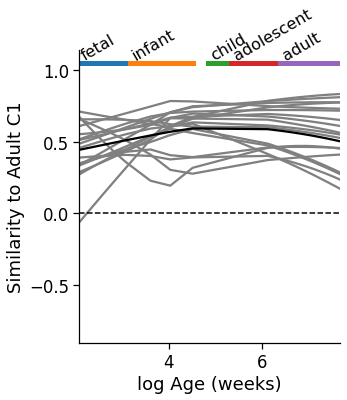

In [272]:
# plot the trajectory of all genes in cluster 5
c9cols = [x+'_r' for x in c1_genes[c1_genes.Cluster==9].Gene.values \
          if x+'_r' in subsum1.columns]
c9plots = pandas.DataFrame(subsum1[subsum1.Species=='Human'][c9cols],copy=True)
#c9plots.drop('labels',inplace=True)
c9plots.loc[:,'ind'] = range(len(c9plots))
c9plots.loc[:,'log_age_weeks'] = subsum.loc[c9plots.index,'log_age_weeks'].values
gtall = pandas.melt(c9plots,id_vars='ind',
                   value_vars=[x for x in c9plots.columns if '_r' in x])
gtall.loc[:,'log_age_weeks'] = c9plots.log_age_weeks.tolist() * len(gtall.variable.unique())

sns.set_context('notebook',font_scale=1.5)
g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',#palette='tab10',
             palette=['gray']*len(gtall.variable.unique()),#palette=colors,
             legend=None,
             data=gtall)
sns.regplot(x=c9plots.log_age_weeks.values,y=c9plots[c9plots.columns[:-2]].mean(1).values,color='black',
           marker='',lowess=True)
plt.ylabel('Similarity to Adult C1')
plt.xlabel('log Age (weeks)')

for stage in qc.Age_Stage.unique():
    levels = qc[qc.Age_Stage==stage]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
#plt.savefig(os.path.join(fig_dir,'EGenes_C1_ClusterTimelines_4Clus1.pdf'),bbox_inches='tight')

### What if we apply the brainspan cluster solution PEC data?

In [582]:
c1tall = pandas.read_csv('data/BSDevGens_C1.csv',index_col=0)
#c1tall = pandas.read_csv('data/BSDevGens_C1_4clus.csv',index_col=0)

In [583]:
to_tfm = pandas.DataFrame(subsum1[[x for x in subsum1 if '_r' in x and 'ho' not in x]],
                          copy=True)

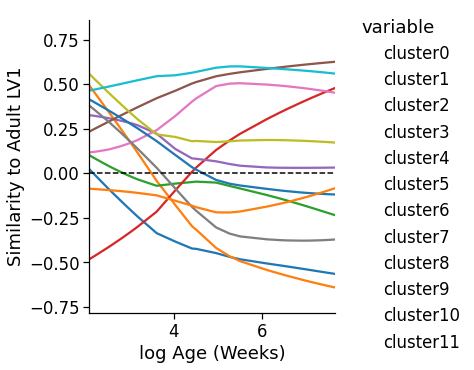

In [584]:
# plot the trajectory of all clusters


sns.set_context('notebook',font_scale=1.5)
g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',palette='tab10',
             #palette=['gray']*len(tall.variable.unique()),#palette=colors,
             #legend=None,
             data=c1tall)
plt.ylabel('Similarity to Adult LV1')
plt.xlabel('log Age (Weeks)')

# for stage in gdf.Age_Stage.unique():
#     levels = gdf[gdf.Age_Stage==stage]['log_age_months'].values
#     xmin = np.min(levels)
#     xmax = np.max(levels)
#     plt.plot([xmin,xmax],[1.05,1.05],lw=5)
#     plt.text(xmin,1.05,stage,fontsize=16,ha='left',
#              va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
#plt.savefig(os.path.join(fig_dir,'EGenes_C1_ClusterTimelines.pdf'),bbox_inches='tight')

In [585]:
# obtain cluster "centroids"
# there is a duplicate timestamp in here that will need to be addressed
# I guess they were twin donors?
fitted = {}
for c in range(len(c1tall.variable.unique())):
    centroid = g.ax.lines[c].get_data()
    dup_ind = list(centroid[0]).index(6.120528161558597)
    newval = (centroid[1][dup_ind] + centroid[1][dup_ind+1])/2
    vector = list(centroid[1][:dup_ind]) + [newval] + list(centroid[1][dup_ind+2:])
    fitted.update({'C%s'%c: np.array(vector)}) 
BS_x = g.ax.lines[0].get_data()[0]
BS_x = pandas.Series(BS_x).drop_duplicates().values
 

In [586]:
subsum1.index = subsum1.Brain.values

In [587]:
qc.Brain.unique()

array(['RMB209', 'RMB228', 'RMB193L', 'RMB202', 'RMB227', 'RMB296',
       'RMB233', 'RMB208', 'RMB200L', 'RMB207', 'RMB201L', 'RMB291',
       'RMB212', 'RMB214', 'RMB213', 'RMB215', 'RMB217', 'RMB188L',
       'RMB216', 'RMB218', 'RMB219', 'RMB199L', 'RMB160', 'RMB177R',
       'RMB196', 'RMB161', 'HSB112', 'HSB148', 'HSB113', 'HSB150',
       'HSB153', 'HSB103', 'HSB114', 'HSB149', 'HSB154', 'HSB178',
       'HSB96', 'HSB97', 'HSB98', 'HSB107', 'HSB92', 'HSB159', 'HSB194',
       'HSB132', 'HSB139', 'HSB171', 'HSB122', 'HSB173', 'HSB172',
       'HSB118', 'HSB141', 'HSB174', 'HSB175', 'HSB124', 'HSB119',
       'HSB127', 'HSB130', 'HSB136', 'HSB126', 'HSB145', 'HSB123',
       'HSB135'], dtype=object)

In [588]:
c9cols = [x+'_r' for x in c1_genes[c1_genes.Cluster==9].Gene.values \
          if x+'_r' in subsum1.columns]
c9plots = pandas.DataFrame(subsum1[subsum1.Species=='Human'][c9cols],copy=True)
#c9plots.drop('labels',inplace=True)
c9plots.loc[:,'ind'] = range(len(c9plots))
c9plots.loc[:,'log_age_weeks'] = subsum.loc[c9plots.index,'log_age_weeks'].values

In [589]:
# map PEC subjects to BS timeline

# get subject - age mapping for each subject
hum_mapping = {}
for i,row in subsum1[subsum1.Species=='Human'].iterrows():
    if i not in c9plots.index: 
        print('not there')
        continue
    age = row['log_age_weeks']
    dists = [abs(x - age) for x in BS_x]
    match = BS_x[np.argmin(dists)]
    if match in hum_mapping.keys():
        hum_mapping.update({match: hum_mapping[match]+[i]})
    else:
        hum_mapping.update({match: [i]})

# maq_mapping = {}
# for i,row in subsum1[subsum1.Species=='Macaque'].iterrows():
#     age = row['log_age_weeks']
#     dists = [abs(x - age) for x in BS_x]
#     match = BS_x[np.argmin(dists)]
#     if match in maq_mapping.keys():
#         maq_mapping.update({match: maq_mapping[match]+[i]})
#     else:
#         maq_mapping.update({match: [i]})
        
# reduce size of BrainSpan x to get rid of ages with no matches
new_BSX = [x for x in BS_x if x in hum_mapping.keys()]

# make new dataframe where PEC data is in matched BrainSpan space
mapped = pandas.DataFrame(columns = c9plots.columns)
for x in new_BSX:
    mapped.loc[x,:] = c9plots.loc[hum_mapping[x]].dropna().mean()

In [590]:
from sklearn.metrics import mean_absolute_error

clust_res = pandas.DataFrame(index = mapped.columns,columns=fitted.keys())
for col in [x for x in mapped.columns if '_r' in x]:
    # get index of the BrainSpan Cluster 5 gene dataframe
    gene = col.split('_')[0]
    gid = c1_genes[c1_genes.Gene==gene].index
    # get the "fitted" values of gene expression over development in PEC
    gvec = mapped[col].dropna()
    # compute distance between individual gene trajectory and centroid trajectory
    dists = pandas.DataFrame(index=fitted.keys(),columns=['dist'])
    for clust,centroid in fitted.items():
        # make sure number of points are the same
        idx = np.array([x for x in range(len(BS_x)) if BS_x[x] in gvec.index])
        dist = mean_absolute_error(centroid[idx],gvec.values)
        dists.loc[clust,'dist'] = dist
        clust_res.loc[col,clust] = dist
    winner = dists.index[np.argmin(dists.dist.values)]
    c1_genes.loc[gid,'PEC_Human_Cluster'] = int(winner.split('C')[1])
    # add information to prune weak relationships
    if any(gvec.values<0):
        c1_genes.loc[gid,'PEC_Gene_Ever_Negative'] = 1
    else:
        c1_genes.loc[gid,'PEC_Gene_Ever_Negative'] = 0
    if any(gvec.values>0.5):
        c1_genes.loc[gid,'PEC_Gene_Ever_R>5'] = 1
    else:
        c1_genes.loc[gid,'PEC_Gene_Ever_R>5'] = 0
    

In [591]:
c1_genes[c1_genes.PEC_Gene_Ever_Negative==0]

,Gene,Cluster,name,PEC_Human_Cluster,PEC_Gene_Ever_Negative,PEC_Gene_Ever_R>5,PEC_Gene_Ever_Positive


In [256]:
# c1_genes[(c1_genes.Cluster==5) & (c1_genes.PEC_Human_Cluster==5) &\]

In [283]:
replicated = c1_genes[(c1_genes.Cluster==9) & (c1_genes.PEC_Human_Cluster==9) &\
                     (c1_genes.PEC_Gene_Ever_Negative==0) & (c1_genes['PEC_Gene_Ever_R>5']==1)
                     ].Gene.values
for x in replicated:
    print(x)

SPON2
SP5
ZIC1
TLL1
C14orf132
LIMK2
LGR6
CCDC88B


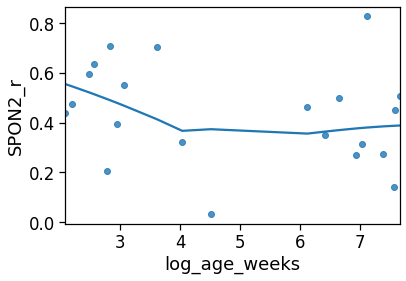

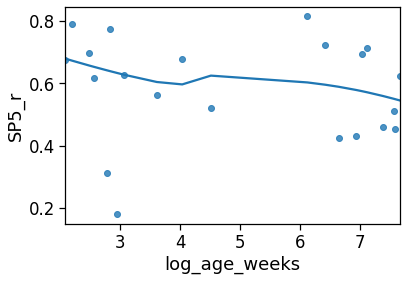

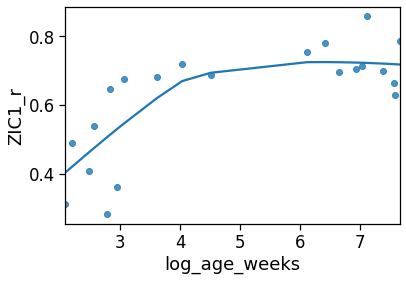

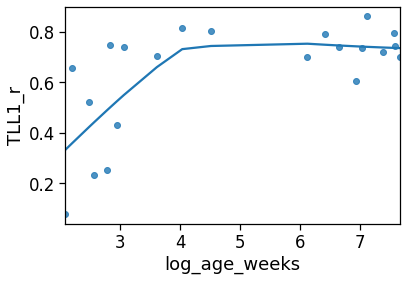

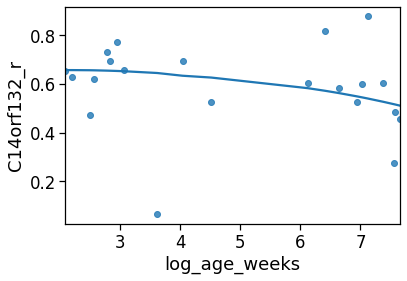

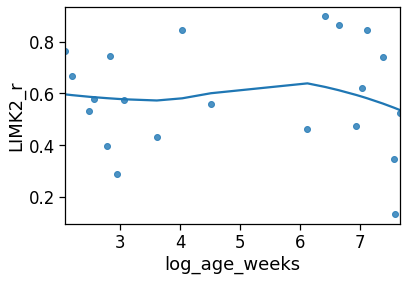

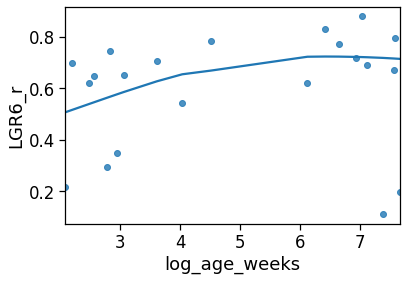

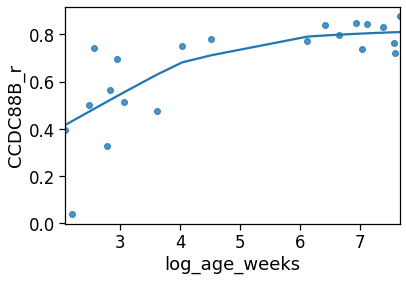

In [284]:
for x in replicated:
    sns.regplot(x='log_age_weeks',y=x+'_r',data=mapped,lowess=True)
    plt.show()

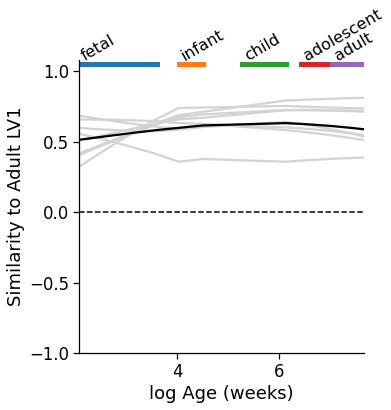

In [285]:
# plot the trajectory of all genes in cluster 9
repcols = [x+'_r' for x in replicated]
repplots = pandas.DataFrame(mapped[repcols],copy=True)
#c9plots.drop('labels',inplace=True)
repplots.loc[:,'ind'] = range(len(repplots))
repplots.loc[:,'log_age_weeks'] = repplots.index.values
for i,x in enumerate(BS_x):
    if x not in hum_mapping.keys():continue
    repplots.loc[x,'C1'] = fitted['C1'][i]
    inds = hum_mapping[x]
    #repplots.loc[x,'closest_brains'] = inds
rtall = pandas.melt(repplots,id_vars='ind',
                   value_vars=[x for x in repplots.columns if '_r' in x])
rtall.loc[:,'log_age_weeks'] = repplots.log_age_weeks.tolist() * len(rtall.variable.unique())
sns.set_context('notebook',font_scale=1.5)
g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',#palette='tab10',
             palette=['lightgray']*len(rtall.variable.unique()),#palette=colors,
             legend=None,
             data=rtall)
sns.regplot(x=repplots.log_age_weeks.values,y=repplots[repcols].mean(1).values,
            color='black',
           marker='',lowess=True)
# sns.regplot(x=repplots.log_age_weeks.values,y=repplots.C9.values,
#             color='blue',line_kws={'ls':'--'},
#            marker='',lowess=True)
# sns.regplot(x=repplots.log_age_weeks.values,y=repplots.PAX6_r.values,
#             color='gray',
#            marker='',lowess=True)
plt.ylabel('Similarity to Adult LV1')
plt.xlabel('log Age (weeks)')
plt.ylim(-1,1.08)
#plt.yticks([-0.5,])


for stage in qc.Age_Stage.unique():
    levels = qc[(qc.Age_Stage==stage) & (qc.Species==species)]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
plt.savefig(os.path.join(fig_dir,'EGenes_C1_ClusterTimelines_Clus9_PEC.pdf'),
            bbox_inches='tight')

### Overlay against C1 trajector for PEC and BS

#### PEC

In [96]:
replicated

array(['SPON2', 'SP5', 'ZIC1', 'TLL1', 'C14orf132', 'LIMK2', 'LGR6',
       'CCDC88B'], dtype=object)

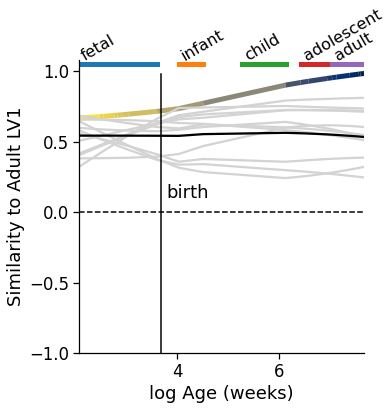

In [204]:
sns.set_context('notebook',font_scale=1.5)

# plot the trajectory of all genes in cluster 9
repcols = [x+'_r' for x in replicated]
# drop 2 genes that didn't pass criteria in brainspan
#repcols = [x for x in repcols if x not in ['TSHZ1_r','GLCE_r']]
repplots = pandas.DataFrame(mapped[repcols],copy=True)
#c9plots.drop('labels',inplace=True)
repplots.loc[:,'ind'] = range(len(repplots))
repplots.loc[:,'log_age_weeks'] = repplots.index.values
# add C9 centroid and PEC C1r in shared subject space
for i,x in enumerate(BS_x):
    if x not in hum_mapping.keys():continue
    # repplots.loc[x,'C9'] = fitted['C9'][i]
    repplots.loc[x,'C1'] = fitted['C1'][i]
    inds = hum_mapping[x]
    repplots.loc[x,'PEC_C1'] = subsum.loc[inds]['C1_r'].mean()
    #repplots.loc[x,'closest_brains'] = inds
rtall = pandas.melt(repplots,id_vars='ind',
                   value_vars=[x for x in repplots.columns if '_r' in x])
rtall.loc[:,'log_age_weeks'] = repplots.log_age_weeks.tolist() * len(rtall.variable.unique())
g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',#palette='tab10',
             palette=['lightgray']*len(rtall.variable.unique()),#palette=colors,
             legend=None,
             data=rtall)
sns.regplot(x=repplots.log_age_weeks.values,y=repplots[repcols].mean(1).values,
            color='black',
           marker='',lowess=True)

m = sns.regplot(x=repplots.log_age_weeks.values,y=repplots.PEC_C1.values,
            color='gray',line_kws={'ls':'--'},
           marker='',lowess=True)
x, y = m.get_lines()[-1].get_data()
segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
norm = plt.Normalize(x.min(), x.max())
lc = LineCollection(segments, cmap='cividis_r', norm=norm)
lc.set_array(x[:-1])
lc.set_linewidth(2)
line = m.add_collection(lc)
plt.setp(line,linewidth=5)
m.get_lines()[-1].remove()
# sns.regplot(x=repplots.log_age_weeks.values,y=repplots.C9.values,
#             color='blue',line_kws={'ls':'--'},
#            marker='',lowess=True)
# sns.regplot(x=repplots.log_age_weeks.values,y=repplots.PAX6_r.values,
#             color='gray',
#            marker='',lowess=True)
plt.ylabel('Similarity to Adult LV1')
plt.xlabel('log Age (weeks)')
plt.ylim(-1,1.08)
#plt.yticks([-0.5,])


for stage in qc.Age_Stage.unique():
    levels = qc[(qc.Age_Stage==stage) & (qc.Species==species)]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
plt.axvline(np.log(40),ymax=0.95,c='k')
plt.text(np.log(40)+0.1,0.1,'birth')
plt.savefig(os.path.join(fig_dir,'EGenes_C1_4Clu1vAll_PEC.pdf'),
            bbox_inches='tight')

In [209]:
# bs
#bsc9 = pandas.read_csv('data/BSDevGens_C1_ss.csv',index_col=0)
bsc9 = pandas.read_csv('data/BSDevGens_C1_ss_4clus.csv',index_col=0)
bs_subsum = pandas.read_csv('data/subsum.csv',index_col=0)

In [210]:
id_bs = bs_subsum[bs_subsum.log_age_weeks.isin(new_BSX)].donor_id.values
id_bs = [x for x in id_bs if x in bsc9.index]
bs_mapped = bsc9.loc[id_bs,repcols]

In [211]:
bs_subsum.index = bs_subsum.donor_id.values

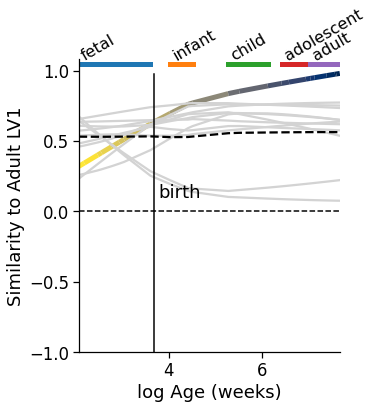

In [212]:
sns.set_context('notebook',font_scale=1.5)

# plot the trajectory of all genes in cluster 9
repplots_bs = pandas.DataFrame(bs_mapped[repcols],copy=True)
#c9plots.drop('labels',inplace=True)
repplots_bs.loc[:,'ind'] = range(len(repplots_bs))
repplots_bs.loc[:,'log_age_weeks'] = bs_subsum.loc[repplots_bs.index,'log_age_weeks']

repplots_bs.loc[:,'BS_C1'] = bs_subsum.loc[repplots_bs.index,'C1_r'].values
rtall_bs = pandas.melt(repplots_bs,id_vars='ind',
                   value_vars=[x for x in repplots_bs.columns if '_r' in x])
rtall_bs.loc[:,'log_age_weeks'] = repplots_bs.log_age_weeks.tolist() * len(rtall_bs.variable.unique())
g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',#palette='tab10',
             palette=['lightgray']*len(rtall_bs.variable.unique()),#palette=colors,
             legend=None,
             data=rtall_bs)
sns.regplot(x=repplots_bs.log_age_weeks.values,y=repplots_bs[repcols].mean(1).values,
            color='black',line_kws={'ls':'--'},
           marker='',lowess=True)
m = sns.regplot(x=repplots_bs.log_age_weeks.values,y=repplots_bs.BS_C1.values,
            color='gray',
           marker='',lowess=True)
x, y = m.get_lines()[-1].get_data()
segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
norm = plt.Normalize(x.min(), x.max())
lc = LineCollection(segments, cmap='cividis_r', norm=norm)
lc.set_array(x[:-1])
lc.set_linewidth(2)
line = m.add_collection(lc)
plt.setp(line,linewidth=5)
m.get_lines()[-1].remove()
# sns.regplot(x=repplots.log_age_weeks.values,y=repplots.C9.values,
#             color='blue',line_kws={'ls':'--'},
#            marker='',lowess=True)
# sns.regplot(x=repplots.log_age_weeks.values,y=repplots.PAX6_r.values,
#             color='gray',
#            marker='',lowess=True)
plt.ylabel('Similarity to Adult LV1')
plt.xlabel('log Age (weeks)')
plt.ylim(-1,1.08)
#plt.yticks([-0.5,])


for stage in qc.Age_Stage.unique():
    levels = qc[(qc.Age_Stage==stage) & (qc.Species==species)]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
plt.axvline(np.log(40),ymax=0.95,c='k')
plt.text(np.log(40)+0.1,0.1,'birth')
plt.savefig(os.path.join(fig_dir,'EGenes_C1_4Clu1vAll_BS.pdf'),
            bbox_inches='tight')

In [104]:
rtall.loc[:,'cohort'] = 'PEC'
rtall_bs.loc[:,'cohort'] = 'BS'
rtall_bs.loc[:,'variable'] = [x+'_BS' for x in rtall_bs.variable.values]
supertall = pandas.concat([rtall,rtall_bs])

Text(3.7888794541139363, 0.1, 'birth')

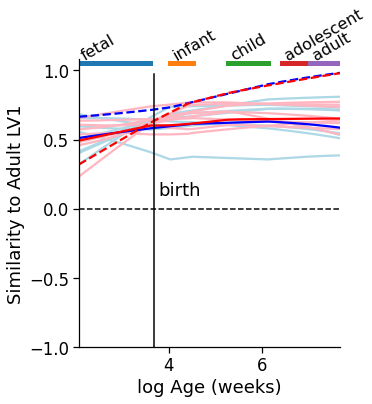

In [105]:
sns.set_context('notebook',font_scale=1.5)

new_pal = ['lightblue']*len(rtall.variable.unique()) + \
          ['lightpink']*len(rtall_bs.variable.unique())

g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',#palette='tab10',
             palette=new_pal,#palette=colors,
             legend=None,
             data=supertall)
sns.regplot(x=repplots.log_age_weeks.values,y=repplots[repcols].mean(1).values,
            color='blue',
           marker='',lowess=True)
sns.regplot(x=repplots_bs.log_age_weeks.values,y=repplots_bs[repcols].mean(1).values,
            color='red',
           marker='',lowess=True)
sns.regplot(x=repplots.log_age_weeks.values,y=repplots.PEC_C1.values,
            color='blue',line_kws={'ls':'--'},
           marker='',lowess=True)
sns.regplot(x=repplots_bs.log_age_weeks.values,y=repplots_bs.BS_C1.values,
            color='red',line_kws={'ls':'--'},
           marker='',lowess=True)
# sns.regplot(x=repplots.log_age_weeks.values,y=repplots.C9.values,
#             color='blue',line_kws={'ls':'--'},
#            marker='',lowess=True)
# sns.regplot(x=repplots.log_age_weeks.values,y=repplots.PAX6_r.values,
#             color='gray',
#            marker='',lowess=True)
plt.ylabel('Similarity to Adult LV1')
plt.xlabel('log Age (weeks)')
plt.ylim(-1,1.08)
#plt.yticks([-0.5,])


for stage in qc.Age_Stage.unique():
    levels = qc[(qc.Age_Stage==stage) & (qc.Species==species)]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
plt.axvline(np.log(40),ymax=0.95,c='k')
plt.text(np.log(40)+0.1,0.1,'birth')
# plt.savefig(os.path.join(fig_dir,'EGenes_C1_Clu9vAll_BS.pdf'),
#             bbox_inches='tight')

#### Try building CIs

In [678]:
pec_fitmat.shape

(8, 18)

In [107]:
bs_fitmat = np.zeros((len(repcols),len(repplots_bs)))
for i,col in enumerate(repcols):
    g = sns.lmplot(x='log_age_weeks',y=col,data=repplots_bs,lowess=True)
    lfit = g.ax.lines[0].get_data()[1]
    bs_fitmat[i,:] = lfit
    plt.close()
bs_min = bs_fitmat.min(0)
bs_max = bs_fitmat.max(0)

pec_fitmat = np.zeros((len(repcols),len(repplots[repcols].dropna())))
for i,col in enumerate(repcols):
    g = sns.lmplot(x='log_age_weeks',y=col,data=repplots,lowess=True)
    lfit = g.ax.lines[0].get_data()[1]
    pec_fitmat[i,:] = lfit
    plt.close()
pec_min = pec_fitmat.min(0)
pec_max = pec_fitmat.max(0)

Text(3.7888794541139363, 0.1, 'birth')

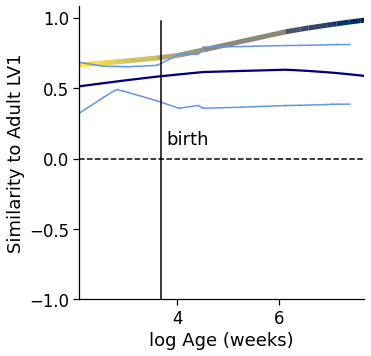

In [135]:
# LV1 trajectories
g=sns.lmplot(x='log_age_weeks',y='PEC_C1',data=repplots,
            line_kws={'ls':'--','color':'navy'},
           markers='',lowess=True,legend=None)
x, y = g.ax.get_lines()[-1].get_data()
segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
norm = plt.Normalize(x.min(), x.max())
lc = LineCollection(segments, cmap='cividis_r', norm=norm)
lc.set_array(x[:-1])
lc.set_linewidth(2)
line = g.ax.add_collection(lc)
plt.setp(line,linewidth=5)
g.ax.get_lines()[-1].remove()
# Avg Non-transitional gene trajectories
sns.regplot(x=repplots.log_age_weeks.values,y=repplots[repcols].mean(1).values,
            color='navy',
           marker='',lowess=True)
# CIs
for i in range(len(pec_min)):
    if i == len(pec_min)-1: continue
    plt.plot([repplots.log_age_weeks.values[i],repplots.log_age_weeks.values[i+1]],
             [pec_min[i],pec_min[i+1]],c='cornflowerblue')
    plt.plot([repplots.log_age_weeks.values[i],repplots.log_age_weeks.values[i+1]],
             [pec_max[i],pec_max[i+1]],c='cornflowerblue')

plt.ylabel('Similarity to Adult LV1')
plt.xlabel('log Age (weeks)')
plt.ylim(-1,1.08)
plt.axhline(0,c='k',ls='--')
plt.axvline(np.log(40),ymax=0.95,c='k')
plt.text(np.log(40)+0.1,0.1,'birth')


Text(3.7888794541139363, 0.1, 'birth')

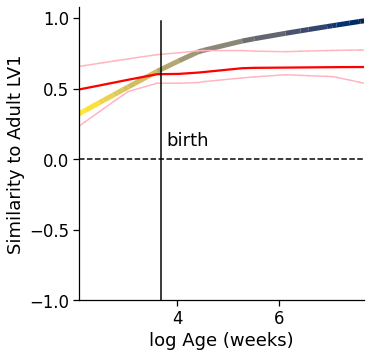

In [138]:
# LV1 trajectories
g=sns.lmplot(x='log_age_weeks',y='BS_C1',data=repplots_bs,
            line_kws={'ls':'--','color':'red'},
           markers='',lowess=True,legend=None)
x, y = g.ax.get_lines()[-1].get_data()
segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
norm = plt.Normalize(x.min(), x.max())
lc = LineCollection(segments, cmap='cividis_r', norm=norm)
lc.set_array(x[:-1])
lc.set_linewidth(2)
line = g.ax.add_collection(lc)
plt.setp(line,linewidth=5)
g.ax.get_lines()[-1].remove()
# Avg Non-transitional gene trajectories
sns.regplot(x=repplots_bs.log_age_weeks.values,y=repplots_bs[repcols].mean(1).values,
            color='red',
           marker='',lowess=True)
# CIs
for i in range(len(bs_min)):
    if i == len(bs_min)-1: continue
    #current_min
    plt.plot([sorted(repplots_bs.log_age_weeks.values)[i],
              sorted(repplots_bs.log_age_weeks.values)[i+1]],
             [bs_min[i],bs_min[i+1]],c='lightpink')
    plt.plot([sorted(repplots_bs.log_age_weeks.values)[i],
              sorted(repplots_bs.log_age_weeks.values)[i+1]],
             [bs_max[i],bs_max[i+1]],c='lightpink')

plt.ylabel('Similarity to Adult LV1')
plt.xlabel('log Age (weeks)')
plt.ylim(-1,1.08)
plt.axhline(0,c='k',ls='--')
plt.axvline(np.log(40),ymax=0.95,c='k')
plt.text(np.log(40)+0.1,0.1,'birth')

In [692]:
i=0
print([repplots_bs.log_age_weeks.values[i],repplots_bs.log_age_weeks.values[i+1]])
print([bs_min[i],bs_min[i+1]])

[2.772588722239781, 7.37719937671931]
[0.334028637855255, 0.334028637855255]


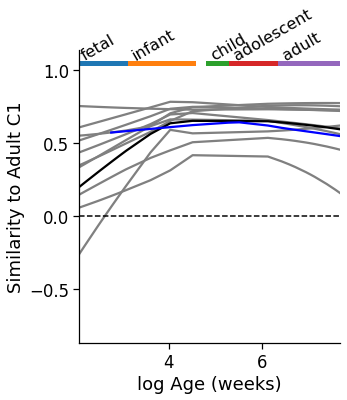

In [448]:
# # plot the trajectory of all genes in cluster 5
# repcols = [x+'_r' for x in replicated]
# #repplots = pandas.DataFrame(subsum1[subsum1.Species=='Human'][repcols],copy=True)
# #c5plots.drop('labels',inplace=True)
# repplots.loc[:,'ind'] = range(len(repplots))
# repplots.loc[:,'log_age_weeks'] = subsum.loc[repplots.index,'log_age_weeks'].values
# for i,x in enumerate(BS_x):
#     if x not in hum_mapping.keys():continue
#     inds = hum_mapping[x]
#     repplots.loc[inds,'C5'] = fitted['C5'][i]
# rtall = pandas.melt(repplots,id_vars='ind',
#                    value_vars=[x for x in repplots.columns if '_r' in x])
# rtall.loc[:,'log_age_weeks'] = repplots.log_age_weeks.tolist() * len(rtall.variable.unique())
# sns.set_context('notebook',font_scale=1.5)
# g=sns.lmplot(x='log_age_weeks',y='value',
#             hue='variable',lowess=True,
#              markers='',#palette='tab10',
#              palette=['gray']*len(rtall.variable.unique()),#palette=colors,
#              legend=None,
#              data=rtall)
# sns.regplot(x=repplots.log_age_weeks.values,y=repplots[repcols].mean(1).values,
#             color='black',
#            marker='',lowess=True)
# sns.regplot(x=repplots.log_age_weeks.values,y=repplots.C5.values,
#             color='blue',
#            marker='',lowess=True)
# plt.ylabel('Similarity to Adult C1')
# plt.xlabel('log Age (weeks)')

# for stage in qc.Age_Stage.unique():
#     levels = qc[qc.Age_Stage==stage]['log_age_weeks'].values
#     xmin = np.min(levels)
#     xmax = np.max(levels)
#     plt.plot([xmin,xmax],[1.05,1.05],lw=5)
#     plt.text(xmin,1.05,stage,fontsize=16,ha='left',
#              va='bottom',rotation=30)
# plt.axhline(0,c='k',ls='--')
# #plt.savefig(os.path.join(fig_dir,'EGenes_C1_ClusterTimelines_Clus5.pdf'),bbox_inches='tight')

# C2

In [486]:
c1_genes = pandas.read_csv('data/C2_devclusters.csv',index_col=0)
#c1_genes = pandas.read_csv('data/C1_devclusters_4clus.csv',index_col=0)
c1_genes.head()

,Gene,Cluster,name
0,MGP,0,non-transitional_neg
1,MET,0,non-transitional_neg
2,TDRD1,1,inverse_neg
3,LXN,1,inverse_neg
4,CPLX2,0,non-transitional_neg


In [289]:
# create individual dfs for each component
c = 2
subsum1 = pandas.DataFrame(index=qc.Brain.unique())
for col in cols:
    subsum1.loc[:,col] = qc.groupby('Brain')[col].first().loc[subsum1.index].values

aba = pandas.read_csv('data/GCorr_BSComp_ABA_C%s_data_ROTATION.csv'%c,
                   index_col=0)
aba.columns = ['ABA_mean','ABA_sem']  

for it,gene in enumerate(c1_genes.Gene.values):
    if gene not in df.index: continue
    qc.loc[:,'C%sGene_exp'%c] = df.loc[gene,qc.Sample].values
    gpdf = qc[['Brain','C%sGene_exp'%c,'MacroStructure']
                  ].set_index(['Brain'],append=True
                             ).pivot_table(index='Brain',
                                           columns='MacroStructure',
                                           values='C%sGene_exp'%c).loc[subsum1.index]
    gpdf.drop('Transient',axis=1,inplace=True)
    for ind,row in gpdf.iterrows():
        n_valid = len([x for x in row.values if pandas.notnull(x)])
        gpdf.loc[ind,'n_valid'] = n_valid
    aba = aba.loc[gpdf.columns[:-1]]
    fail = False
    for i,row in gpdf.iterrows():
        forcorr = pandas.DataFrame(aba,copy=True)
        # if subject has 6+ regions with data
        if row['n_valid'] > 5:
            # find similarity to Allen expression
            forcorr.loc[:,'gvec'] = row.values[:-1]
            forcorr.dropna(inplace=True)
            if all(forcorr['gvec'].values == forcorr['gvec'].values[0]): 
                fail = True
                continue
            r = stats.pearsonr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            rho = stats.spearmanr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            # store values
            gpdf.loc[i,'%s_r'%gene] = r
            gpdf.loc[i,'%s_rho'%gene] = rho
    # store per gene information for each subject -- r, rho and n_valid
    if fail == True: continue
#     subsum1.loc[:,'%s_r'%gene] = gpdf.loc[subsum1.index,'%s_r'%gene].values
#     subsum1.loc[:,'%s_rho'%gene] = gpdf.loc[subsum1.index,'%s_rho'%gene].values
#     subsum1.loc[:,'n_valid'] = gpdf.loc[subsum1.index,'n_valid'].values
    subsum1.loc[:,'%s_r'%gene] = gpdf.loc[:,'%s_r'%gene].values
    subsum1.loc[:,'%s_rho'%gene] = gpdf.loc[:,'%s_rho'%gene].values
    subsum1.loc[:,'n_valid'] = gpdf.loc[:,'n_valid'].values

In [487]:
c5cols = [x+'_r' for x in c1_genes[c1_genes.Cluster==3].Gene.values \
          if x+'_r' in subsum1.columns]
c5plots = pandas.DataFrame(subsum1[subsum1.Species=='Human'][c5cols],copy=True)

In [488]:
c5plots.iloc[:,:-2].mean(0).sort_values(ascending=False)

KCNA5_r       0.624677
RBP1_r        0.575904
LRRN1_r       0.532268
MGAT4C_r      0.531019
DRD2_r        0.494867
SIX3_r        0.487095
VWA5A_r       0.468802
ZMYND10_r     0.467449
SKAP1_r       0.449608
AMIGO2_r      0.445610
CNGB1_r       0.429799
TP53I3_r      0.421600
FANK1_r       0.417419
STXBP6_r      0.412591
SYT10_r       0.405951
BMP8B_r       0.399039
CLIC5_r       0.370679
TSPAN2_r      0.362664
SEMA5A_r      0.362281
HSPB8_r       0.362030
DNALI1_r      0.361680
CDH11_r       0.352978
CTXN3_r       0.350274
HRH3_r        0.334311
EDN1_r        0.331831
NMB_r         0.331263
IL33_r        0.326028
SLC30A10_r    0.320985
GABRE_r       0.306727
CHI3L1_r      0.288600
AGT_r         0.287446
CST3_r        0.280647
WNT10A_r      0.277199
NR2F2_r       0.260020
LRPAP1_r      0.255620
HHAT_r        0.246515
MEIS2_r       0.234750
PLOD2_r       0.231602
CD86_r        0.228688
MEI1_r        0.224504
SLFN11_r      0.198029
TRPV2_r       0.190765
MTHFD2L_r     0.182527
SNX31_r    

In [411]:
subsum.index = subsum.Brain.values

### Plot genes that were non-transitional for Brainspan

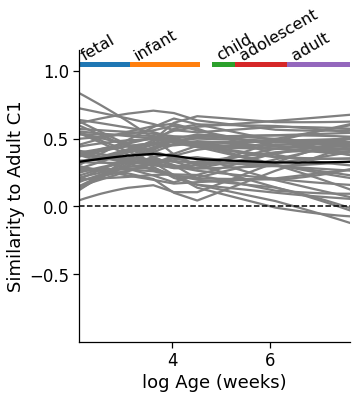

In [489]:
# plot the trajectory of all genes in cluster 5
c9cols = [x+'_r' for x in c1_genes[c1_genes.Cluster==3].Gene.values \
          if x+'_r' in subsum1.columns]
c9plots = pandas.DataFrame(subsum1[subsum1.Species=='Human'][c9cols],copy=True)
#c9plots.drop('labels',inplace=True)
c9plots.loc[:,'ind'] = range(len(c9plots))
c9plots.loc[:,'log_age_weeks'] = subsum.loc[c9plots.index,'log_age_weeks'].values
gtall = pandas.melt(c9plots,id_vars='ind',
                   value_vars=[x for x in c9plots.columns if '_r' in x])
gtall.loc[:,'log_age_weeks'] = c9plots.log_age_weeks.tolist() * len(gtall.variable.unique())

sns.set_context('notebook',font_scale=1.5)
g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',#palette='tab10',
             palette=['gray']*len(gtall.variable.unique()),#palette=colors,
             legend=None,
             data=gtall)
sns.regplot(x=c9plots.log_age_weeks.values,y=c9plots[c9plots.columns[:-2]].mean(1).values,color='black',
           marker='',lowess=True)
plt.ylabel('Similarity to Adult C1')
plt.xlabel('log Age (weeks)')

for stage in qc.Age_Stage.unique():
    levels = qc[qc.Age_Stage==stage]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
plt.savefig(os.path.join(fig_dir,'EGenes_C2_ClusterTimelines_7Clus3.pdf'),bbox_inches='tight')

### What if we apply the brainspan cluster solution PEC data?

In [490]:
c1tall = pandas.read_csv('data/BSDevGens_C2_7clus.csv',index_col=0)

In [491]:
to_tfm = pandas.DataFrame(subsum1[[x for x in subsum1 if '_r' in x and 'ho' not in x]],
                          copy=True)

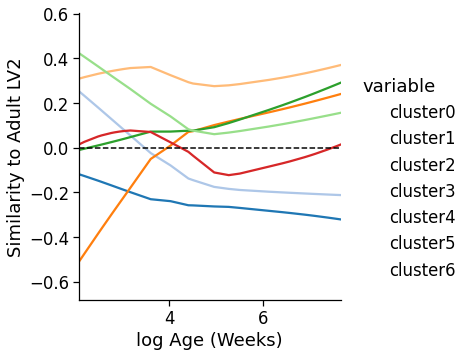

In [492]:
# plot the trajectory of all clusters


sns.set_context('notebook',font_scale=1.5)
g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',palette='tab20',
             #palette=['gray']*len(tall.variable.unique()),#palette=colors,
             #legend=None,
             data=c1tall)
plt.ylabel('Similarity to Adult LV2')
plt.xlabel('log Age (Weeks)')

# for stage in gdf.Age_Stage.unique():
#     levels = gdf[gdf.Age_Stage==stage]['log_age_months'].values
#     xmin = np.min(levels)
#     xmax = np.max(levels)
#     plt.plot([xmin,xmax],[1.05,1.05],lw=5)
#     plt.text(xmin,1.05,stage,fontsize=16,ha='left',
#              va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
#plt.savefig(os.path.join(fig_dir,'EGenes_C1_ClusterTimelines.pdf'),bbox_inches='tight')

In [493]:
# obtain cluster "centroids"
# there is a duplicate timestamp in here that will need to be addressed
# I guess they were twin donors?
fitted = {}
for c in range(len(c1tall.variable.unique())):
    centroid = g.ax.lines[c].get_data()
    dup_ind = list(centroid[0]).index(6.120528161558597)
    newval = (centroid[1][dup_ind] + centroid[1][dup_ind+1])/2
    vector = list(centroid[1][:dup_ind]) + [newval] + list(centroid[1][dup_ind+2:])
    fitted.update({'C%s'%c: np.array(vector)}) 
BS_x = g.ax.lines[0].get_data()[0]
BS_x = pandas.Series(BS_x).drop_duplicates().values
 

In [417]:
subsum1.index = subsum1.Brain.values

In [418]:
qc.Brain.unique()

array(['RMB209', 'RMB228', 'RMB193L', 'RMB202', 'RMB227', 'RMB296',
       'RMB233', 'RMB208', 'RMB200L', 'RMB207', 'RMB201L', 'RMB291',
       'RMB212', 'RMB214', 'RMB213', 'RMB215', 'RMB217', 'RMB188L',
       'RMB216', 'RMB218', 'RMB219', 'RMB199L', 'RMB160', 'RMB177R',
       'RMB196', 'RMB161', 'HSB112', 'HSB148', 'HSB113', 'HSB150',
       'HSB153', 'HSB103', 'HSB114', 'HSB149', 'HSB154', 'HSB178',
       'HSB96', 'HSB97', 'HSB98', 'HSB107', 'HSB92', 'HSB159', 'HSB194',
       'HSB132', 'HSB139', 'HSB171', 'HSB122', 'HSB173', 'HSB172',
       'HSB118', 'HSB141', 'HSB174', 'HSB175', 'HSB124', 'HSB119',
       'HSB127', 'HSB130', 'HSB136', 'HSB126', 'HSB145', 'HSB123',
       'HSB135'], dtype=object)

In [494]:
c9cols = [x+'_r' for x in c1_genes[c1_genes.Cluster==3].Gene.values \
          if x+'_r' in subsum1.columns]
c9plots = pandas.DataFrame(subsum1[subsum1.Species=='Human'][c9cols],copy=True)
#c9plots.drop('labels',inplace=True)
c9plots.loc[:,'ind'] = range(len(c9plots))
c9plots.loc[:,'log_age_weeks'] = subsum.loc[c9plots.index,'log_age_weeks'].values

In [495]:
# map PEC subjects to BS timeline

# get subject - age mapping for each subject
hum_mapping = {}
for i,row in subsum1[subsum1.Species=='Human'].iterrows():
    if i not in c9plots.index: 
        print('not there')
        continue
    age = row['log_age_weeks']
    dists = [abs(x - age) for x in BS_x]
    match = BS_x[np.argmin(dists)]
    if match in hum_mapping.keys():
        hum_mapping.update({match: hum_mapping[match]+[i]})
    else:
        hum_mapping.update({match: [i]})

# maq_mapping = {}
# for i,row in subsum1[subsum1.Species=='Macaque'].iterrows():
#     age = row['log_age_weeks']
#     dists = [abs(x - age) for x in BS_x]
#     match = BS_x[np.argmin(dists)]
#     if match in maq_mapping.keys():
#         maq_mapping.update({match: maq_mapping[match]+[i]})
#     else:
#         maq_mapping.update({match: [i]})
        
# reduce size of BrainSpan x to get rid of ages with no matches
new_BSX = [x for x in BS_x if x in hum_mapping.keys()]

# make new dataframe where PEC data is in matched BrainSpan space
mapped = pandas.DataFrame(columns = c9plots.columns)
for x in new_BSX:
    mapped.loc[x,:] = c9plots.loc[hum_mapping[x]].dropna().mean()

In [496]:
from sklearn.metrics import mean_absolute_error

clust_res = pandas.DataFrame(index = mapped.columns,columns=fitted.keys())
for col in [x for x in mapped.columns if '_r' in x]:
    # get index of the BrainSpan Cluster 5 gene dataframe
    gene = col.split('_')[0]
    gid = c1_genes[c1_genes.Gene==gene].index
    # get the "fitted" values of gene expression over development in PEC
    gvec = mapped[col].dropna()
    # compute distance between individual gene trajectory and centroid trajectory
    dists = pandas.DataFrame(index=fitted.keys(),columns=['dist'])
    for clust,centroid in fitted.items():
        # make sure number of points are the same
        idx = np.array([x for x in range(len(BS_x)) if BS_x[x] in gvec.index])
        dist = mean_absolute_error(centroid[idx],gvec.values)
        dists.loc[clust,'dist'] = dist
        clust_res.loc[col,clust] = dist
    winner = dists.index[np.argmin(dists.dist.values)]
    c1_genes.loc[gid,'PEC_Human_Cluster'] = int(winner.split('C')[1])
    # add information to prune weak relationships
    if any(gvec.values<0):
        c1_genes.loc[gid,'PEC_Gene_Ever_Negative'] = 1
    else:
        c1_genes.loc[gid,'PEC_Gene_Ever_Negative'] = 0
#     if any(gvec.values>0):
#         c1_genes.loc[gid,'PEC_Gene_Ever_Positive'] = 1
#     else:
#         c1_genes.loc[gid,'PEC_Gene_Ever_Positive'] = 0
    if any(gvec.values>0.5):
        c1_genes.loc[gid,'PEC_Gene_Ever_R>5'] = 1
    else:
        c1_genes.loc[gid,'PEC_Gene_Ever_R>5'] = 0
#     if any(gvec.values<-0.5):
#         c1_genes.loc[gid,'PEC_Gene_Ever_R>5'] = 1
#     else:
#         c1_genes.loc[gid,'PEC_Gene_Ever_R>5'] = 0
    

In [497]:
c1_genes[c1_genes.PEC_Human_Cluster==3]

,Gene,Cluster,name,PEC_Human_Cluster,PEC_Gene_Ever_Negative,PEC_Gene_Ever_R>5
7,TP53I3,3,non_transitional_pos,3.0,1.0,1.0
10,NR2F2,3,non_transitional_pos,3.0,1.0,1.0
14,SLFN11,3,non_transitional_pos,3.0,1.0,1.0
40,CD86,3,non_transitional_pos,3.0,1.0,1.0
46,AGT,3,non_transitional_pos,3.0,1.0,1.0
54,GABRE,3,non_transitional_pos,3.0,1.0,1.0
68,DRD2,3,non_transitional_pos,3.0,1.0,1.0
89,CST3,3,non_transitional_pos,3.0,1.0,1.0
101,LRPAP1,3,non_transitional_pos,3.0,1.0,1.0
107,CHI3L1,3,non_transitional_pos,3.0,1.0,1.0


In [256]:
# c1_genes[(c1_genes.Cluster==5) & (c1_genes.PEC_Human_Cluster==5) &\]

In [503]:
replicated = c1_genes[(c1_genes.Cluster==3) & (c1_genes.PEC_Human_Cluster==3) &\
                     (c1_genes.PEC_Gene_Ever_Negative==0) & (c1_genes['PEC_Gene_Ever_R>5']==1)
                     ].Gene.values
for x in replicated:
    print(x)

FANK1
LRRN1
KCNA5
SKAP1
VWA5A
RBP1
SIX3
MGAT4C
HRH3
HSPB8
ZMYND10


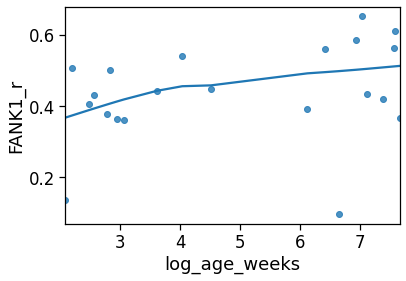

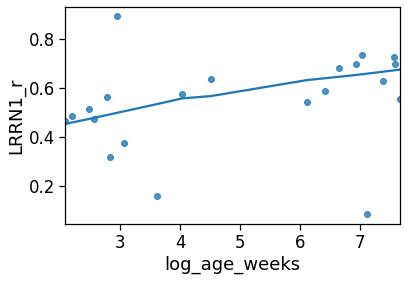

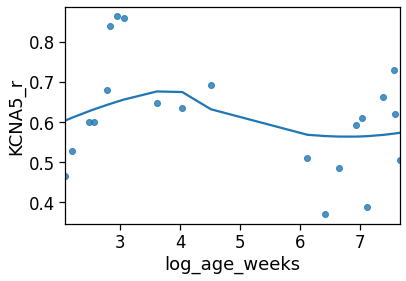

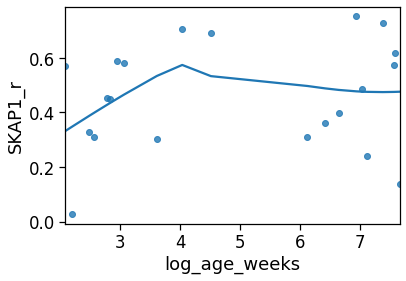

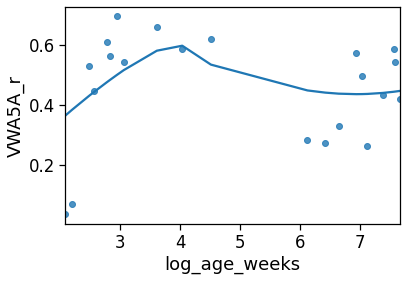

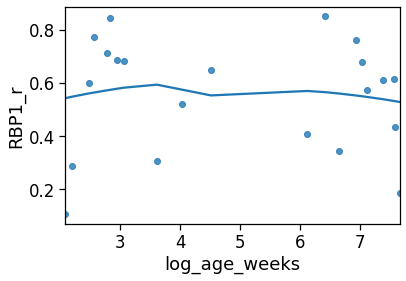

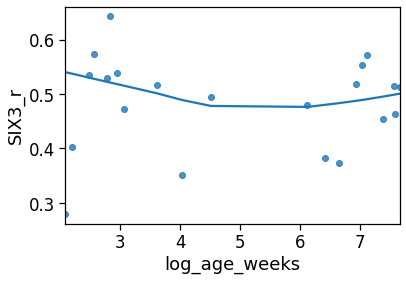

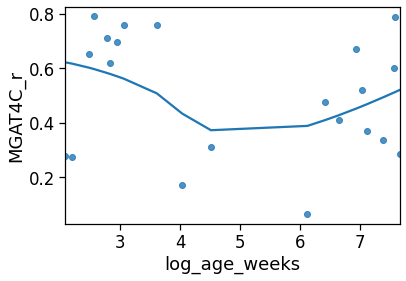

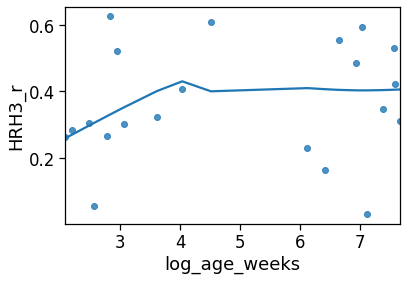

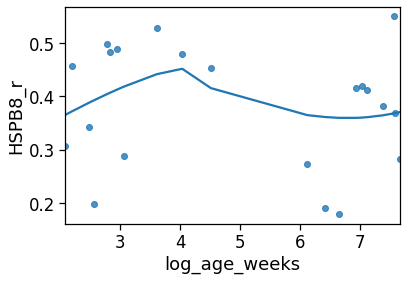

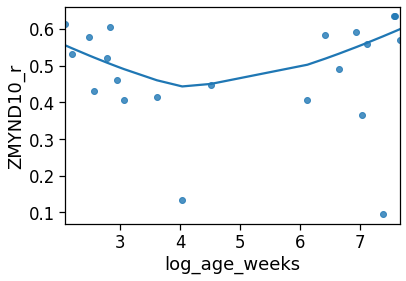

In [504]:
for x in replicated:
    sns.regplot(x='log_age_weeks',y=x+'_r',data=mapped,lowess=True)
    plt.show()

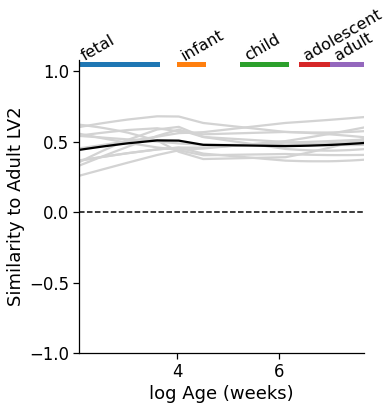

In [505]:
# plot the trajectory of all genes in cluster 9
repcols = [x+'_r' for x in replicated]
repplots = pandas.DataFrame(mapped[repcols],copy=True)
#c9plots.drop('labels',inplace=True)
repplots.loc[:,'ind'] = range(len(repplots))
repplots.loc[:,'log_age_weeks'] = repplots.index.values
for i,x in enumerate(BS_x):
    if x not in hum_mapping.keys():continue
    repplots.loc[x,'C3'] = fitted['C3'][i]
    inds = hum_mapping[x]
    #repplots.loc[x,'closest_brains'] = inds
rtall = pandas.melt(repplots,id_vars='ind',
                   value_vars=[x for x in repplots.columns if '_r' in x])
rtall.loc[:,'log_age_weeks'] = repplots.log_age_weeks.tolist() * len(rtall.variable.unique())
sns.set_context('notebook',font_scale=1.5)
g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',#palette='tab10',
             palette=['lightgray']*len(rtall.variable.unique()),#palette=colors,
             legend=None,
             data=rtall)
sns.regplot(x=repplots.log_age_weeks.values,y=repplots[repcols].mean(1).values,
            color='black',
           marker='',lowess=True)
# sns.regplot(x=repplots.log_age_weeks.values,y=repplots.C9.values,
#             color='blue',line_kws={'ls':'--'},
#            marker='',lowess=True)
# sns.regplot(x=repplots.log_age_weeks.values,y=repplots.PAX6_r.values,
#             color='gray',
#            marker='',lowess=True)
plt.ylabel('Similarity to Adult LV2')
plt.xlabel('log Age (weeks)')
plt.ylim(-1,1.08)
#plt.yticks([-0.5,])


for stage in qc.Age_Stage.unique():
    levels = qc[(qc.Age_Stage==stage) & (qc.Species==species)]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
plt.savefig(os.path.join(fig_dir,'EGenes_C2_ClusterTimelines_Clus3_PEC.pdf'),
            bbox_inches='tight')

### Overlay against C2 trajector for PEC and BS

#### PEC

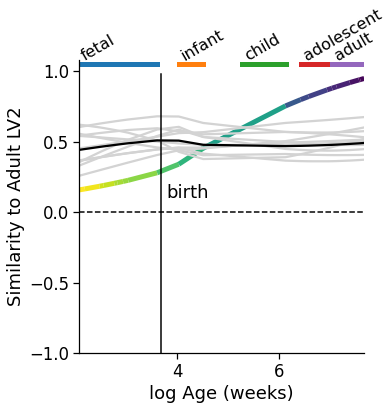

In [506]:
sns.set_context('notebook',font_scale=1.5)

# plot the trajectory of all genes in cluster 9
repcols = [x+'_r' for x in replicated]
# drop 2 genes that didn't pass criteria in brainspan
#repcols = [x for x in repcols if x not in ['TSHZ1_r','GLCE_r']]
repplots = pandas.DataFrame(mapped[repcols],copy=True)
#c9plots.drop('labels',inplace=True)
repplots.loc[:,'ind'] = range(len(repplots))
repplots.loc[:,'log_age_weeks'] = repplots.index.values
# add C9 centroid and PEC C1r in shared subject space
for i,x in enumerate(BS_x):
    if x not in hum_mapping.keys():continue
    # repplots.loc[x,'C9'] = fitted['C9'][i]
    repplots.loc[x,'C3'] = fitted['C3'][i]
    inds = hum_mapping[x]
    repplots.loc[x,'PEC_C2'] = subsum.loc[inds]['C2_r'].mean()
    #repplots.loc[x,'closest_brains'] = inds
rtall = pandas.melt(repplots,id_vars='ind',
                   value_vars=[x for x in repplots.columns if '_r' in x])
rtall.loc[:,'log_age_weeks'] = repplots.log_age_weeks.tolist() * len(rtall.variable.unique())
g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',#palette='tab10',
             palette=['lightgray']*len(rtall.variable.unique()),#palette=colors,
             legend=None,
             data=rtall)
sns.regplot(x=repplots.log_age_weeks.values,y=repplots[repcols].mean(1).values,
            color='black',
           marker='',lowess=True)

m = sns.regplot(x=repplots.log_age_weeks.values,y=repplots.PEC_C2.values,
            color='gray',line_kws={'ls':'--'},
           marker='',lowess=True)
x, y = m.get_lines()[-1].get_data()
segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
norm = plt.Normalize(x.min(), x.max())
lc = LineCollection(segments, cmap='viridis_r', norm=norm)
lc.set_array(x[:-1])
lc.set_linewidth(2)
line = m.add_collection(lc)
plt.setp(line,linewidth=5)
m.get_lines()[-1].remove()
# sns.regplot(x=repplots.log_age_weeks.values,y=repplots.C9.values,
#             color='blue',line_kws={'ls':'--'},
#            marker='',lowess=True)
# sns.regplot(x=repplots.log_age_weeks.values,y=repplots.PAX6_r.values,
#             color='gray',
#            marker='',lowess=True)
plt.ylabel('Similarity to Adult LV2')
plt.xlabel('log Age (weeks)')
plt.ylim(-1,1.08)
#plt.yticks([-0.5,])


for stage in qc.Age_Stage.unique():
    levels = qc[(qc.Age_Stage==stage) & (qc.Species==species)]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
plt.axvline(np.log(40),ymax=0.95,c='k')
plt.text(np.log(40)+0.1,0.1,'birth')
plt.savefig(os.path.join(fig_dir,'EGenes_C2_7Clu3vAll_PEC.pdf'),
            bbox_inches='tight')

In [507]:
# bs
#bsc9 = pandas.read_csv('data/BSDevGens_C1_ss.csv',index_col=0)
bsc9 = pandas.read_csv('data/BSDevGens_C2_ss_7clus.csv',index_col=0)
bs_subsum = pandas.read_csv('data/subsum.csv',index_col=0)

In [508]:
id_bs = bs_subsum[bs_subsum.log_age_weeks.isin(new_BSX)].donor_id.values
id_bs = [x for x in id_bs if x in bsc9.index]
bs_mapped = bsc9.loc[id_bs,repcols]

In [509]:
bs_subsum.index = bs_subsum.donor_id.values

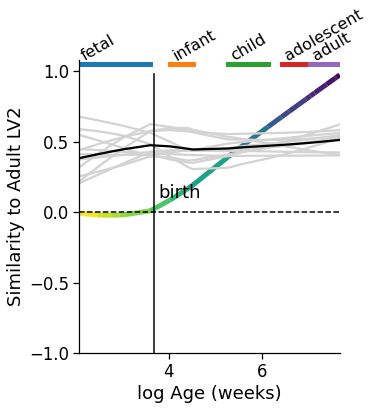

In [511]:
sns.set_context('notebook',font_scale=1.5)

# plot the trajectory of all genes in cluster 9
repplots_bs = pandas.DataFrame(bs_mapped[repcols],copy=True)
#c9plots.drop('labels',inplace=True)
repplots_bs.loc[:,'ind'] = range(len(repplots_bs))
repplots_bs.loc[:,'log_age_weeks'] = bs_subsum.loc[repplots_bs.index,'log_age_weeks']

repplots_bs.loc[:,'BS_C2'] = bs_subsum.loc[repplots_bs.index,'C2_r'].values
rtall_bs = pandas.melt(repplots_bs,id_vars='ind',
                   value_vars=[x for x in repplots_bs.columns if '_r' in x])
rtall_bs.loc[:,'log_age_weeks'] = repplots_bs.log_age_weeks.tolist() * len(rtall_bs.variable.unique())
g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',#palette='tab10',
             palette=['lightgray']*len(rtall_bs.variable.unique()),#palette=colors,
             legend=None,
             data=rtall_bs)
sns.regplot(x=repplots_bs.log_age_weeks.values,y=repplots_bs[repcols].mean(1).values,
            color='black',#line_kws={'ls':'--'},
           marker='',lowess=True)
m = sns.regplot(x=repplots_bs.log_age_weeks.values,y=repplots_bs.BS_C2.values,
            color='gray',
           marker='',lowess=True)
x, y = m.get_lines()[-1].get_data()
segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
norm = plt.Normalize(x.min(), x.max())
lc = LineCollection(segments, cmap='viridis_r', norm=norm)
lc.set_array(x[:-1])
lc.set_linewidth(2)
line = m.add_collection(lc)
plt.setp(line,linewidth=5)
m.get_lines()[-1].remove()
# sns.regplot(x=repplots.log_age_weeks.values,y=repplots.C9.values,
#             color='blue',line_kws={'ls':'--'},
#            marker='',lowess=True)
# sns.regplot(x=repplots.log_age_weeks.values,y=repplots.PAX6_r.values,
#             color='gray',
#            marker='',lowess=True)
plt.ylabel('Similarity to Adult LV2')
plt.xlabel('log Age (weeks)')
plt.ylim(-1,1.08)
#plt.yticks([-0.5,])


for stage in qc.Age_Stage.unique():
    levels = qc[(qc.Age_Stage==stage) & (qc.Species==species)]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
plt.axvline(np.log(40),ymax=0.95,c='k')
plt.text(np.log(40)+0.1,0.1,'birth')
plt.savefig(os.path.join(fig_dir,'EGenes_C2_7Clu3vAll_BS.pdf'),
            bbox_inches='tight')

In [747]:
qc[qc.Species=='Macaque'].age_in_weeks.value_counts()

595.710000    48
75.710000     46
15.714286     44
8.571429      32
54.125000     32
127.710000    31
387.710000    18
11.714286     16
24.000000     16
205.710000    15
283.710000    15
15.857143     14
231.710000    13
23.714286     11
11.571429     10
11.428571      5
Name: age_in_weeks, dtype: int64

# C3

In [557]:
c1_genes = pandas.read_csv('data/C3_devclusters.csv',index_col=0)
#c1_genes = pandas.read_csv('data/C1_devclusters_4clus.csv',index_col=0)
c1_genes.head()

,Gene,Cluster,name
0,MGP,10,earlydevvalley_neg2
1,TNFSF13B,10,earlydevvalley_neg2
2,CYP26B1,0,nontransient_weakneg
3,PNMT,6,neg_rising
4,C1R,1,earlydevvalley_neg


In [513]:
# create individual dfs for each component
c = 3
subsum1 = pandas.DataFrame(index=qc.Brain.unique())
for col in cols:
    subsum1.loc[:,col] = qc.groupby('Brain')[col].first().loc[subsum1.index].values

aba = pandas.read_csv('data/GCorr_BSComp_ABA_C%s_data_ROTATION.csv'%c,
                   index_col=0)
aba.columns = ['ABA_mean','ABA_sem']  

for it,gene in enumerate(c1_genes.Gene.values):
    if gene not in df.index: continue
    qc.loc[:,'C%sGene_exp'%c] = df.loc[gene,qc.Sample].values
    gpdf = qc[['Brain','C%sGene_exp'%c,'MacroStructure']
                  ].set_index(['Brain'],append=True
                             ).pivot_table(index='Brain',
                                           columns='MacroStructure',
                                           values='C%sGene_exp'%c).loc[subsum1.index]
    gpdf.drop('Transient',axis=1,inplace=True)
    for ind,row in gpdf.iterrows():
        n_valid = len([x for x in row.values if pandas.notnull(x)])
        gpdf.loc[ind,'n_valid'] = n_valid
    aba = aba.loc[gpdf.columns[:-1]]
    fail = False
    for i,row in gpdf.iterrows():
        forcorr = pandas.DataFrame(aba,copy=True)
        # if subject has 6+ regions with data
        if row['n_valid'] > 5:
            # find similarity to Allen expression
            forcorr.loc[:,'gvec'] = row.values[:-1]
            forcorr.dropna(inplace=True)
            if all(forcorr['gvec'].values == forcorr['gvec'].values[0]): 
                fail = True
                continue
            r = stats.pearsonr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            rho = stats.spearmanr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            # store values
            gpdf.loc[i,'%s_r'%gene] = r
            gpdf.loc[i,'%s_rho'%gene] = rho
    # store per gene information for each subject -- r, rho and n_valid
    if fail == True: continue
#     subsum1.loc[:,'%s_r'%gene] = gpdf.loc[subsum1.index,'%s_r'%gene].values
#     subsum1.loc[:,'%s_rho'%gene] = gpdf.loc[subsum1.index,'%s_rho'%gene].values
#     subsum1.loc[:,'n_valid'] = gpdf.loc[subsum1.index,'n_valid'].values
    subsum1.loc[:,'%s_r'%gene] = gpdf.loc[:,'%s_r'%gene].values
    subsum1.loc[:,'%s_rho'%gene] = gpdf.loc[:,'%s_rho'%gene].values
    subsum1.loc[:,'n_valid'] = gpdf.loc[:,'n_valid'].values

In [514]:
c5cols = [x+'_r' for x in c1_genes[c1_genes.Cluster==15].Gene.values \
          if x+'_r' in subsum1.columns]
c5plots = pandas.DataFrame(subsum1[subsum1.Species=='Human'][c5cols],copy=True)

In [515]:
c5plots.iloc[:,:-2].mean(0).sort_values(ascending=False)

ERLIN1_r   -0.225909
PID1_r     -0.337887
dtype: float64

### Plot genes that were non-transitional for Brainspan

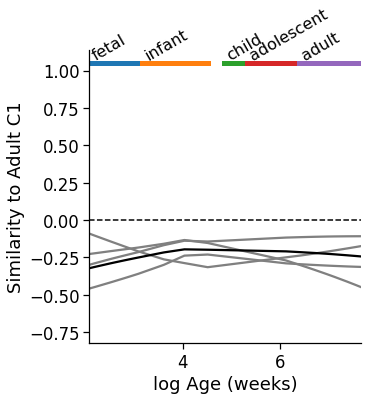

In [516]:
# plot the trajectory of all genes in cluster 5
c9cols = [x+'_r' for x in c1_genes[c1_genes.Cluster==15].Gene.values \
          if x+'_r' in subsum1.columns]
c9plots = pandas.DataFrame(subsum1[subsum1.Species=='Human'][c9cols],copy=True)
#c9plots.drop('labels',inplace=True)
c9plots.loc[:,'ind'] = range(len(c9plots))
c9plots.loc[:,'log_age_weeks'] = subsum.loc[c9plots.index,'log_age_weeks'].values
gtall = pandas.melt(c9plots,id_vars='ind',
                   value_vars=[x for x in c9plots.columns if '_r' in x])
gtall.loc[:,'log_age_weeks'] = c9plots.log_age_weeks.tolist() * len(gtall.variable.unique())

sns.set_context('notebook',font_scale=1.5)
g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',#palette='tab10',
             palette=['gray']*len(gtall.variable.unique()),#palette=colors,
             legend=None,
             data=gtall)
sns.regplot(x=c9plots.log_age_weeks.values,y=c9plots[c9plots.columns[:-2]].mean(1).values,color='black',
           marker='',lowess=True)
plt.ylabel('Similarity to Adult C1')
plt.xlabel('log Age (weeks)')

for stage in qc.Age_Stage.unique():
    levels = qc[qc.Age_Stage==stage]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
plt.savefig(os.path.join(fig_dir,'EGenes_C3_ClusterTimelines_17Clus15.pdf'),bbox_inches='tight')

### What if we apply the brainspan cluster solution PEC data?

In [519]:
c1tall = pandas.read_csv('data/BSDevGens_C3_17clus.csv',index_col=0)

In [520]:
to_tfm = pandas.DataFrame(subsum1[[x for x in subsum1 if '_r' in x and 'ho' not in x]],
                          copy=True)

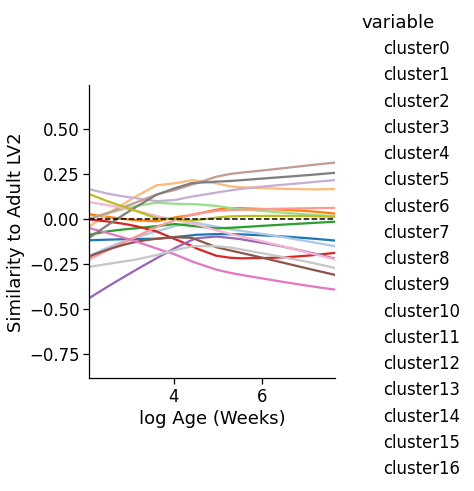

In [521]:
# plot the trajectory of all clusters


sns.set_context('notebook',font_scale=1.5)
g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',palette='tab20',
             #palette=['gray']*len(tall.variable.unique()),#palette=colors,
             #legend=None,
             data=c1tall)
plt.ylabel('Similarity to Adult LV2')
plt.xlabel('log Age (Weeks)')

# for stage in gdf.Age_Stage.unique():
#     levels = gdf[gdf.Age_Stage==stage]['log_age_months'].values
#     xmin = np.min(levels)
#     xmax = np.max(levels)
#     plt.plot([xmin,xmax],[1.05,1.05],lw=5)
#     plt.text(xmin,1.05,stage,fontsize=16,ha='left',
#              va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
#plt.savefig(os.path.join(fig_dir,'EGenes_C1_ClusterTimelines.pdf'),bbox_inches='tight')

In [522]:
# obtain cluster "centroids"
# there is a duplicate timestamp in here that will need to be addressed
# I guess they were twin donors?
fitted = {}
for c in range(len(c1tall.variable.unique())):
    centroid = g.ax.lines[c].get_data()
    dup_ind = list(centroid[0]).index(6.120528161558597)
    newval = (centroid[1][dup_ind] + centroid[1][dup_ind+1])/2
    vector = list(centroid[1][:dup_ind]) + [newval] + list(centroid[1][dup_ind+2:])
    fitted.update({'C%s'%c: np.array(vector)}) 
BS_x = g.ax.lines[0].get_data()[0]
BS_x = pandas.Series(BS_x).drop_duplicates().values
 

In [523]:
subsum1.index = subsum1.Brain.values

In [524]:
qc.Brain.unique()

array(['RMB209', 'RMB228', 'RMB193L', 'RMB202', 'RMB227', 'RMB296',
       'RMB233', 'RMB208', 'RMB200L', 'RMB207', 'RMB201L', 'RMB291',
       'RMB212', 'RMB214', 'RMB213', 'RMB215', 'RMB217', 'RMB188L',
       'RMB216', 'RMB218', 'RMB219', 'RMB199L', 'RMB160', 'RMB177R',
       'RMB196', 'RMB161', 'HSB112', 'HSB148', 'HSB113', 'HSB150',
       'HSB153', 'HSB103', 'HSB114', 'HSB149', 'HSB154', 'HSB178',
       'HSB96', 'HSB97', 'HSB98', 'HSB107', 'HSB92', 'HSB159', 'HSB194',
       'HSB132', 'HSB139', 'HSB171', 'HSB122', 'HSB173', 'HSB172',
       'HSB118', 'HSB141', 'HSB174', 'HSB175', 'HSB124', 'HSB119',
       'HSB127', 'HSB130', 'HSB136', 'HSB126', 'HSB145', 'HSB123',
       'HSB135'], dtype=object)

In [525]:
c9cols = [x+'_r' for x in c1_genes[c1_genes.Cluster==15].Gene.values \
          if x+'_r' in subsum1.columns]
c9plots = pandas.DataFrame(subsum1[subsum1.Species=='Human'][c9cols],copy=True)
#c9plots.drop('labels',inplace=True)
c9plots.loc[:,'ind'] = range(len(c9plots))
c9plots.loc[:,'log_age_weeks'] = subsum.loc[c9plots.index,'log_age_weeks'].values

In [526]:
# map PEC subjects to BS timeline

# get subject - age mapping for each subject
hum_mapping = {}
for i,row in subsum1[subsum1.Species=='Human'].iterrows():
    if i not in c9plots.index: 
        print('not there')
        continue
    age = row['log_age_weeks']
    dists = [abs(x - age) for x in BS_x]
    match = BS_x[np.argmin(dists)]
    if match in hum_mapping.keys():
        hum_mapping.update({match: hum_mapping[match]+[i]})
    else:
        hum_mapping.update({match: [i]})

# maq_mapping = {}
# for i,row in subsum1[subsum1.Species=='Macaque'].iterrows():
#     age = row['log_age_weeks']
#     dists = [abs(x - age) for x in BS_x]
#     match = BS_x[np.argmin(dists)]
#     if match in maq_mapping.keys():
#         maq_mapping.update({match: maq_mapping[match]+[i]})
#     else:
#         maq_mapping.update({match: [i]})
        
# reduce size of BrainSpan x to get rid of ages with no matches
new_BSX = [x for x in BS_x if x in hum_mapping.keys()]

# make new dataframe where PEC data is in matched BrainSpan space
mapped = pandas.DataFrame(columns = c9plots.columns)
for x in new_BSX:
    mapped.loc[x,:] = c9plots.loc[hum_mapping[x]].dropna().mean()

In [551]:
mapped.columns

Index(['PID1_r', 'ERLIN1_r', 'LIG1_r', 'RHCG_r', 'ind', 'log_age_weeks'], dtype='object')

In [564]:
from sklearn.metrics import mean_absolute_error

clust_res = pandas.DataFrame(index = mapped.columns,columns=fitted.keys())
for col in [x for x in mapped.columns if '_r' in x]:
    # get index of the BrainSpan Cluster 5 gene dataframe
    gene = col.split('_')[0]
    gid = c1_genes[c1_genes.Gene==gene].index
    # get the "fitted" values of gene expression over development in PEC
    gvec = mapped[col].dropna()
    # compute distance between individual gene trajectory and centroid trajectory
    dists = pandas.DataFrame(index=fitted.keys(),columns=['dist'])
    for clust,centroid in fitted.items():
        # make sure number of points are the same
        idx = np.array([x for x in range(len(BS_x)) if BS_x[x] in gvec.index])
        dist = mean_absolute_error(centroid[idx],gvec.values)
        dists.loc[clust,'dist'] = dist
        clust_res.loc[col,clust] = dist
    winner = dists.index[np.argmin(dists.dist.values)]
    c1_genes.loc[gid,'PEC_Human_Cluster'] = int(winner.split('C')[1])
    # add information to prune weak relationships
    if any(gvec.values>0):
        c1_genes.loc[gid,'PEC_Gene_Ever_Positive'] = 1
    else:
        c1_genes.loc[gid,'PEC_Gene_Ever_Positive'] = 0
    if any(gvec.values<-0.5):
        c1_genes.loc[gid,'PEC_Gene_Ever_R>5'] = 1
    else:
        c1_genes.loc[gid,'PEC_Gene_Ever_R>5'] = 0
    

In [565]:
c1_genes[(c1_genes.Cluster==15)]

,Gene,Cluster,name,PEC_Human_Cluster,PEC_Gene_Ever_Negative,PEC_Gene_Ever_R>5,PEC_Gene_Ever_Positive
78,PID1,15,nontransient_neg,15.0,1.0,1.0,0.0
97,ERLIN1,15,nontransient_neg,12.0,1.0,1.0,1.0
114,LIG1,15,nontransient_neg,15.0,1.0,1.0,1.0
146,RHCG,15,nontransient_neg,0.0,1.0,0.0,1.0
150,EFNB1,15,nontransient_neg,NaN,NaN,NaN,NaN


In [256]:
# c1_genes[(c1_genes.Cluster==5) & (c1_genes.PEC_Human_Cluster==5) &\]

In [566]:
replicated = c1_genes[(c1_genes.Cluster==15) & (c1_genes.PEC_Human_Cluster==15) &\
                     (c1_genes.PEC_Gene_Ever_Positive==0) & (c1_genes['PEC_Gene_Ever_R>5']==1)
                     ].Gene.values
for x in replicated:
    print(x)

PID1


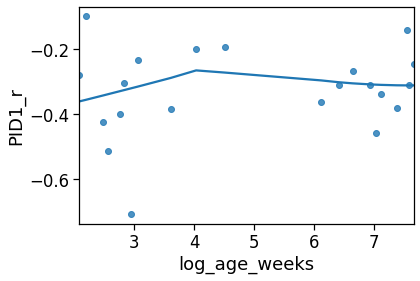

In [567]:
for x in replicated:
    sns.regplot(x='log_age_weeks',y=x+'_r',data=mapped,lowess=True)
    plt.show()

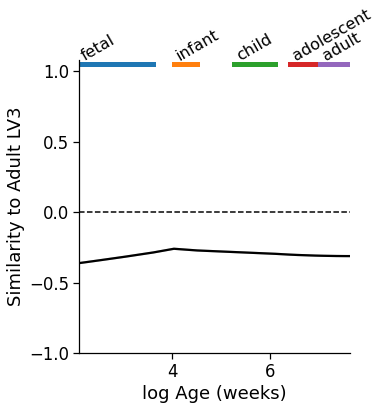

In [569]:
# plot the trajectory of all genes in cluster 9
repcols = [x+'_r' for x in replicated]
repplots = pandas.DataFrame(mapped[repcols],copy=True)
#c9plots.drop('labels',inplace=True)
repplots.loc[:,'ind'] = range(len(repplots))
repplots.loc[:,'log_age_weeks'] = repplots.index.values
for i,x in enumerate(BS_x):
    if x not in hum_mapping.keys():continue
    repplots.loc[x,'C3'] = fitted['C3'][i]
    inds = hum_mapping[x]
    #repplots.loc[x,'closest_brains'] = inds
rtall = pandas.melt(repplots,id_vars='ind',
                   value_vars=[x for x in repplots.columns if '_r' in x])
rtall.loc[:,'log_age_weeks'] = repplots.log_age_weeks.tolist() * len(rtall.variable.unique())
sns.set_context('notebook',font_scale=1.5)
g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',#palette='tab10',
             palette=['lightgray']*len(rtall.variable.unique()),#palette=colors,
             legend=None,
             data=rtall)
sns.regplot(x=repplots.log_age_weeks.values,y=repplots[repcols].mean(1).values,
            color='black',
           marker='',lowess=True)
# sns.regplot(x=repplots.log_age_weeks.values,y=repplots.C9.values,
#             color='blue',line_kws={'ls':'--'},
#            marker='',lowess=True)
# sns.regplot(x=repplots.log_age_weeks.values,y=repplots.PAX6_r.values,
#             color='gray',
#            marker='',lowess=True)
plt.ylabel('Similarity to Adult LV3')
plt.xlabel('log Age (weeks)')
plt.ylim(-1,1.08)
#plt.yticks([-0.5,])


for stage in qc.Age_Stage.unique():
    levels = qc[(qc.Age_Stage==stage) & (qc.Species==species)]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
plt.savefig(os.path.join(fig_dir,'EGenes_C3_ClusterTimelines_Clus15_PEC.pdf'),
            bbox_inches='tight')

### Overlay against C2 trajector for PEC and BS

#### PEC

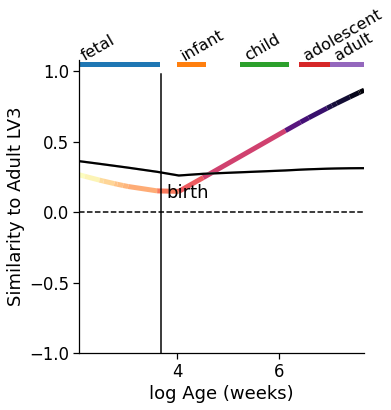

In [575]:
sns.set_context('notebook',font_scale=1.5)

# plot the trajectory of all genes in cluster 9
repcols = [x+'_r' for x in replicated]
# drop 2 genes that didn't pass criteria in brainspan
#repcols = [x for x in repcols if x not in ['TSHZ1_r','GLCE_r']]
repplots = pandas.DataFrame(mapped[repcols],copy=True)
#c9plots.drop('labels',inplace=True)
repplots.loc[:,'ind'] = range(len(repplots))
repplots.loc[:,'log_age_weeks'] = repplots.index.values
# add C9 centroid and PEC C1r in shared subject space
for i,x in enumerate(BS_x):
    if x not in hum_mapping.keys():continue
    # repplots.loc[x,'C9'] = fitted['C9'][i]
    repplots.loc[x,'C15'] = fitted['C15'][i]
    inds = hum_mapping[x]
    repplots.loc[x,'PEC_C3'] = subsum.loc[inds]['C3_r'].mean()
    #repplots.loc[x,'closest_brains'] = inds
rtall = pandas.melt(repplots,id_vars='ind',
                   value_vars=[x for x in repplots.columns if '_r' in x])
rtall.loc[:,'log_age_weeks'] = repplots.log_age_weeks.tolist() * len(rtall.variable.unique())
# invert
rtall.loc[:,'value'] = rtall.loc[:,'value'].values * -1
g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',#palette='tab10',
             palette=['lightgray']*len(rtall.variable.unique()),#palette=colors,
             legend=None,
             data=rtall)
sns.regplot(x=repplots.log_age_weeks.values,y=(repplots[repcols].mean(1).values *-1),
            color='black',
           marker='',lowess=True)

m = sns.regplot(x=repplots.log_age_weeks.values,y=repplots.PEC_C3.values,
            color='gray',line_kws={'ls':'--'},
           marker='',lowess=True)
x, y = m.get_lines()[-1].get_data()
segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
norm = plt.Normalize(x.min(), x.max())
lc = LineCollection(segments, cmap='magma_r', norm=norm)
lc.set_array(x[:-1])
lc.set_linewidth(2)
line = m.add_collection(lc)
plt.setp(line,linewidth=5)
m.get_lines()[-1].remove()
# sns.regplot(x=repplots.log_age_weeks.values,y=repplots.C9.values,
#             color='blue',line_kws={'ls':'--'},
#            marker='',lowess=True)
# sns.regplot(x=repplots.log_age_weeks.values,y=repplots.PAX6_r.values,
#             color='gray',
#            marker='',lowess=True)
plt.ylabel('Similarity to Adult LV3')
plt.xlabel('log Age (weeks)')
plt.ylim(-1,1.08)
#plt.yticks([-0.5,])


for stage in qc.Age_Stage.unique():
    levels = qc[(qc.Age_Stage==stage) & (qc.Species==species)]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
plt.axvline(np.log(40),ymax=0.95,c='k')
plt.text(np.log(40)+0.1,0.1,'birth')
plt.savefig(os.path.join(fig_dir,'EGenes_C3_17Clu15vAll_PEC.pdf'),
            bbox_inches='tight')

In [578]:
# bs
#bsc9 = pandas.read_csv('data/BSDevGens_C1_ss.csv',index_col=0)
bsc9 = pandas.read_csv('data/BSDevGens_C3_ss_17clus.csv',index_col=0)
bs_subsum = pandas.read_csv('data/subsum.csv',index_col=0)

In [579]:
id_bs = bs_subsum[bs_subsum.log_age_weeks.isin(new_BSX)].donor_id.values
id_bs = [x for x in id_bs if x in bsc9.index]
bs_mapped = bsc9.loc[id_bs,repcols]

In [580]:
bs_subsum.index = bs_subsum.donor_id.values

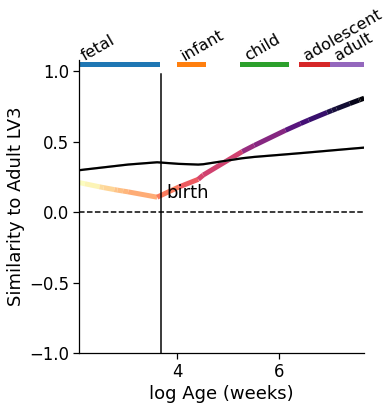

In [581]:
sns.set_context('notebook',font_scale=1.5)

# plot the trajectory of all genes in cluster 9
repplots_bs = pandas.DataFrame(bs_mapped[repcols],copy=True)
#c9plots.drop('labels',inplace=True)
repplots_bs.loc[:,'ind'] = range(len(repplots_bs))
repplots_bs.loc[:,'log_age_weeks'] = bs_subsum.loc[repplots_bs.index,'log_age_weeks']

repplots_bs.loc[:,'BS_C3'] = bs_subsum.loc[repplots_bs.index,'C3_r'].values
rtall_bs = pandas.melt(repplots_bs,id_vars='ind',
                   value_vars=[x for x in repplots_bs.columns if '_r' in x])
rtall_bs.loc[:,'log_age_weeks'] = repplots_bs.log_age_weeks.tolist() * len(rtall_bs.variable.unique())
# invert
rtall_bs.loc[:,'value'] = rtall_bs.loc[:,'value'].values * -1
g=sns.lmplot(x='log_age_weeks',y='value',
            hue='variable',lowess=True,
             markers='',#palette='tab10',
             palette=['lightgray']*len(rtall_bs.variable.unique()),#palette=colors,
             legend=None,
             data=rtall_bs)
sns.regplot(x=repplots_bs.log_age_weeks.values,y=(repplots_bs[repcols].mean(1).values*-1),
            color='black',#line_kws={'ls':'--'},
           marker='',lowess=True)
m = sns.regplot(x=repplots_bs.log_age_weeks.values,y=repplots_bs.BS_C3.values,
            color='gray',
           marker='',lowess=True)
x, y = m.get_lines()[-1].get_data()
segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
norm = plt.Normalize(x.min(), x.max())
lc = LineCollection(segments, cmap='magma_r', norm=norm)
lc.set_array(x[:-1])
lc.set_linewidth(2)
line = m.add_collection(lc)
plt.setp(line,linewidth=5)
m.get_lines()[-1].remove()
# sns.regplot(x=repplots.log_age_weeks.values,y=repplots.C9.values,
#             color='blue',line_kws={'ls':'--'},
#            marker='',lowess=True)
# sns.regplot(x=repplots.log_age_weeks.values,y=repplots.PAX6_r.values,
#             color='gray',
#            marker='',lowess=True)
plt.ylabel('Similarity to Adult LV3')
plt.xlabel('log Age (weeks)')
plt.ylim(-1,1.08)
#plt.yticks([-0.5,])


for stage in qc.Age_Stage.unique():
    levels = qc[(qc.Age_Stage==stage) & (qc.Species==species)]['log_age_weeks'].values
    xmin = np.min(levels)
    xmax = np.max(levels)
    plt.plot([xmin,xmax],[1.05,1.05],lw=5)
    plt.text(xmin,1.05,stage,fontsize=16,ha='left',
             va='bottom',rotation=30)
plt.axhline(0,c='k',ls='--')
plt.axvline(np.log(40),ymax=0.95,c='k')
plt.text(np.log(40)+0.1,0.1,'birth')
plt.savefig(os.path.join(fig_dir,'EGenes_C3_17Clu15vAll_BS.pdf'),
            bbox_inches='tight')

# Primate

#### New mappin

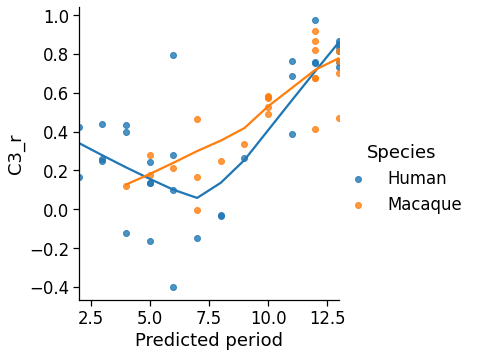

In [630]:
sns.lmplot(x='Predicted period',y='C3_r',hue='Species',data=subsum,lowess=True)

In [631]:
# stage
s4 = ['E60']
s5 = ['E80','E81','E82']
s7 = ['E110','E111']
s8 = ['P0','P2']
s10 = ['7M','1Y']
s12 = ['2Y','3.5Y','4Y','5Y','7Y']
s13 = ['11Y']
divs = [s4,s5,s7,s8,s10,s12,s13]
names = [4,5,7,8,10,12,13]
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    subsum.loc[subsum[(subsum.Age.isin(div)) & (subsum.Species=='Macaque')
                     ].index,'Period'] = name

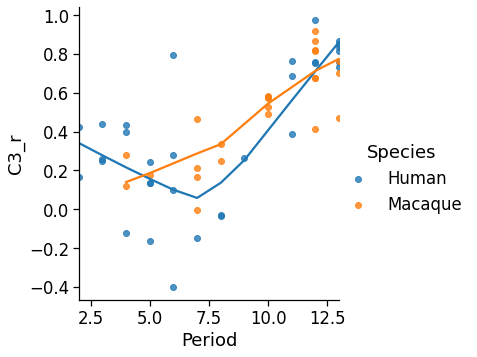

In [635]:
sns.lmplot(x='Period',y='C3_r',hue='Species',data=subsum,lowess=True)

In [722]:
combined = pandas.DataFrame(subsum[['Brain','Species','Period',
                                   'C1_r','C2_r','C3_r']],
                           copy=True)
combined.columns = ['Brain','Species','Period','LV1_r','LV2_r','LV3_r']
combined.loc[:,'Species'] = ['PEC '+x for x in combined.Species.values]
combined

,Brain,Species,Period,LV1_r,LV2_r,LV3_r
HSB103,HSB103,PEC Human,4.0,0.891309,-0.059911,0.398958
HSB107,HSB107,PEC Human,6.0,0.733492,0.328259,0.795981
HSB112,HSB112,PEC Human,2.0,0.673625,0.407330,0.422063
HSB113,HSB113,PEC Human,3.0,0.951497,0.222249,0.439873
HSB114,HSB114,PEC Human,4.0,0.341195,0.504577,-0.124464
...,...,...,...,...,...,...
RMB227,RMB227,PEC Macaque,5.0,NaN,NaN,NaN
RMB228,RMB228,PEC Macaque,4.0,0.770472,0.197544,0.280818
RMB233,RMB233,PEC Macaque,7.0,0.827185,0.043031,0.168609
RMB291,RMB291,PEC Macaque,10.0,0.963077,0.533361,0.579521


In [723]:
bsubsum = pandas.read_csv('data/subsum.csv',
                         index_col=0)
tocombine = pandas.DataFrame(bsubsum[['donor_id','Age_Period','C1_r','C2_r','C3_r']],
                            copy=True)
tocombine.columns = ['Brain','Period','LV1_r','LV2_r','LV3_r']
tocombine.loc[:,'Species'] = 'BS Human'
tocombine.loc[:,'Period'] = [float(x.split('p')[1]) for x in tocombine.Period.values]
combined = pandas.concat([combined,tocombine])

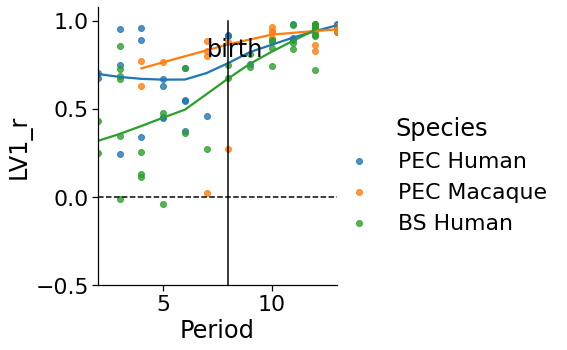

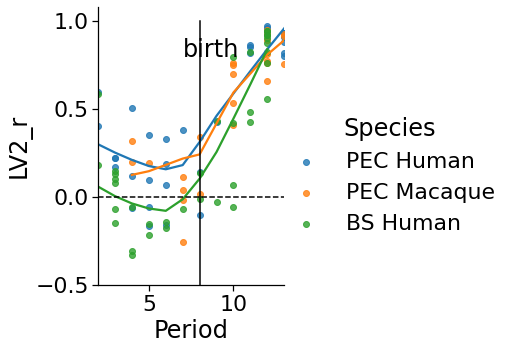

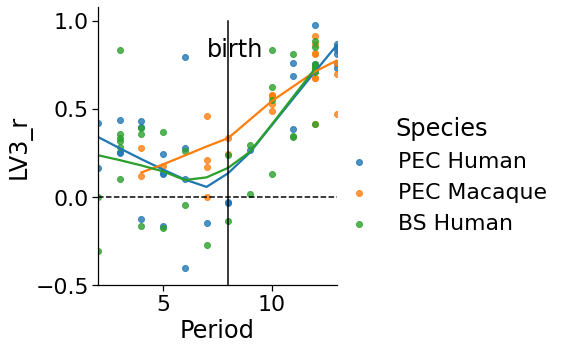

In [726]:
for i in range(1,4):
    sns.lmplot(x='Period',y='LV%s_r'%i,hue='Species',data=combined,lowess=True)
    plt.ylim(-0.5,1.08)
    plt.axhline(0,ls='--',c='k')
    plt.axvline(8,ymax=0.95,c='k')
    plt.text(7,0.8,'birth')
    plt.show()

In [727]:
combined.index = combined.Brain.values

In [728]:
repsets = {1:['SPON2', 'SP5', 'ZIC1', 'TLL1', 'C14orf132', 'LIMK2', 'LGR6', 'CCDC88B'],
          2: ['FANK1', 'LRRN1', 'KCNA5', 'SKAP1', 'VWA5A', 'RBP1', 'SIX3', 'MGAT4C', 
              'HRH3', 'HSPB8', 'ZMYND10'],
          3: ['PID1']}

In [729]:
pecind = combined[combined.Species.isin(['PEC Human','PEC Macaque'])].index
bsind = combined[combined.Species=='BS Human'].index
for c in range(1,4):
    bsdf = pandas.read_csv('data/TESTBioInf_rvals_C%s_rotated.csv'%c,index_col=0)
    # create individual dfs for each component
    aba = pandas.read_csv('data/GCorr_BSComp_ABA_C%s_data_ROTATION.csv'%c,
                       index_col=0)
    aba.columns = ['ABA_mean','ABA_sem']  

    for gene in repsets[c]:
        combined.loc[bsind,gene+'_r'] = bsdf.loc[bsind,gene+'_r'].values
        if gene not in df.index: continue
        qc.loc[:,'C%sGene_exp'%c] = df.loc[gene,qc.Sample].values
        gpdf = qc[['Brain','C%sGene_exp'%c,'MacroStructure']
                      ].set_index(['Brain'],append=True
                                 ).pivot_table(index='Brain',
                                               columns='MacroStructure',
                                               values='C%sGene_exp'%c).loc[pecind]
        gpdf.drop('Transient',axis=1,inplace=True)
        for ind,row in gpdf.iterrows():
            n_valid = len([x for x in row.values if pandas.notnull(x)])
            gpdf.loc[ind,'n_valid'] = n_valid
        aba = aba.loc[gpdf.columns[:-1]]
        fail = False
        for i,row in gpdf.iterrows():
            forcorr = pandas.DataFrame(aba,copy=True)
            # if subject has 6+ regions with data
            if row['n_valid'] > 5:
                # find similarity to Allen expression
                forcorr.loc[:,'gvec'] = row.values[:-1]
                forcorr.dropna(inplace=True)
                if all(forcorr['gvec'].values == forcorr['gvec'].values[0]): 
                    fail = True
                    continue
                r = stats.pearsonr(forcorr['ABA_mean'].values,
                                  forcorr['gvec'].values)[0]
#                 rho = stats.spearmanr(forcorr['ABA_mean'].values,
#                                   forcorr['gvec'].values)[0]
                 # store values
                gpdf.loc[i,'%s_r'%gene] = r
#                 gpdf.loc[i,'%s_rho'%gene] = rho
        # store per gene information for each subject -- r, rho and n_valid
        if fail == True: continue
        combined.loc[pecind,'%s_r'%gene] = gpdf.loc[pecind,'%s_r'%gene].values
        #combined.loc[pecind,'%s_rho'%gene] = gpdf.loc[pecind,'%s_rho'%gene].values
        combined.loc[pecind,'n_valid'] = gpdf.loc[pecind,'n_valid'].values
    
    

In [730]:
combined.loc[:,'PID1_r'] = combined.PID1_r.values *-1

In [701]:
combined.columns

Index(['Brain', 'Species', 'Period', 'C1_r', 'C2_r', 'C3_r', 'SPON2_r',
       'n_valid', 'SP5_r', 'ZIC1_r', 'TLL1_r', 'C14orf132_r', 'LIMK2_r',
       'LGR6_r', 'CCDC88B_r', 'FANK1_r', 'LRRN1_r', 'KCNA5_r', 'SKAP1_r',
       'VWA5A_r', 'RBP1_r', 'SIX3_r', 'MGAT4C_r', 'HRH3_r', 'HSPB8_r',
       'ZMYND10_r', 'PID1_r', 'ind'],
      dtype='object')

In [731]:
combined.loc[:,'ind'] = range(len(combined))
gcols = [x for x in combined.columns if '_r' in x]
combtall = combined.melt(id_vars='ind',value_vars=gcols)
for col in ['Brain','Species','Period']:
    combtall.loc[:,col] = combined[col].tolist() * len(gcols)

In [732]:
for i,x in enumerate(product(list(range(4)),list(range(6)))):
    if i == 23: break
    gind = combtall[combtall.variable==gcols[i]].index
    combtall.loc[gind,'row'] = x[0]
    combtall.loc[gind,'col'] = x[1]

In [742]:
[x for x in repsets.keys() if 'SP5' in repsets[x]]

[1]

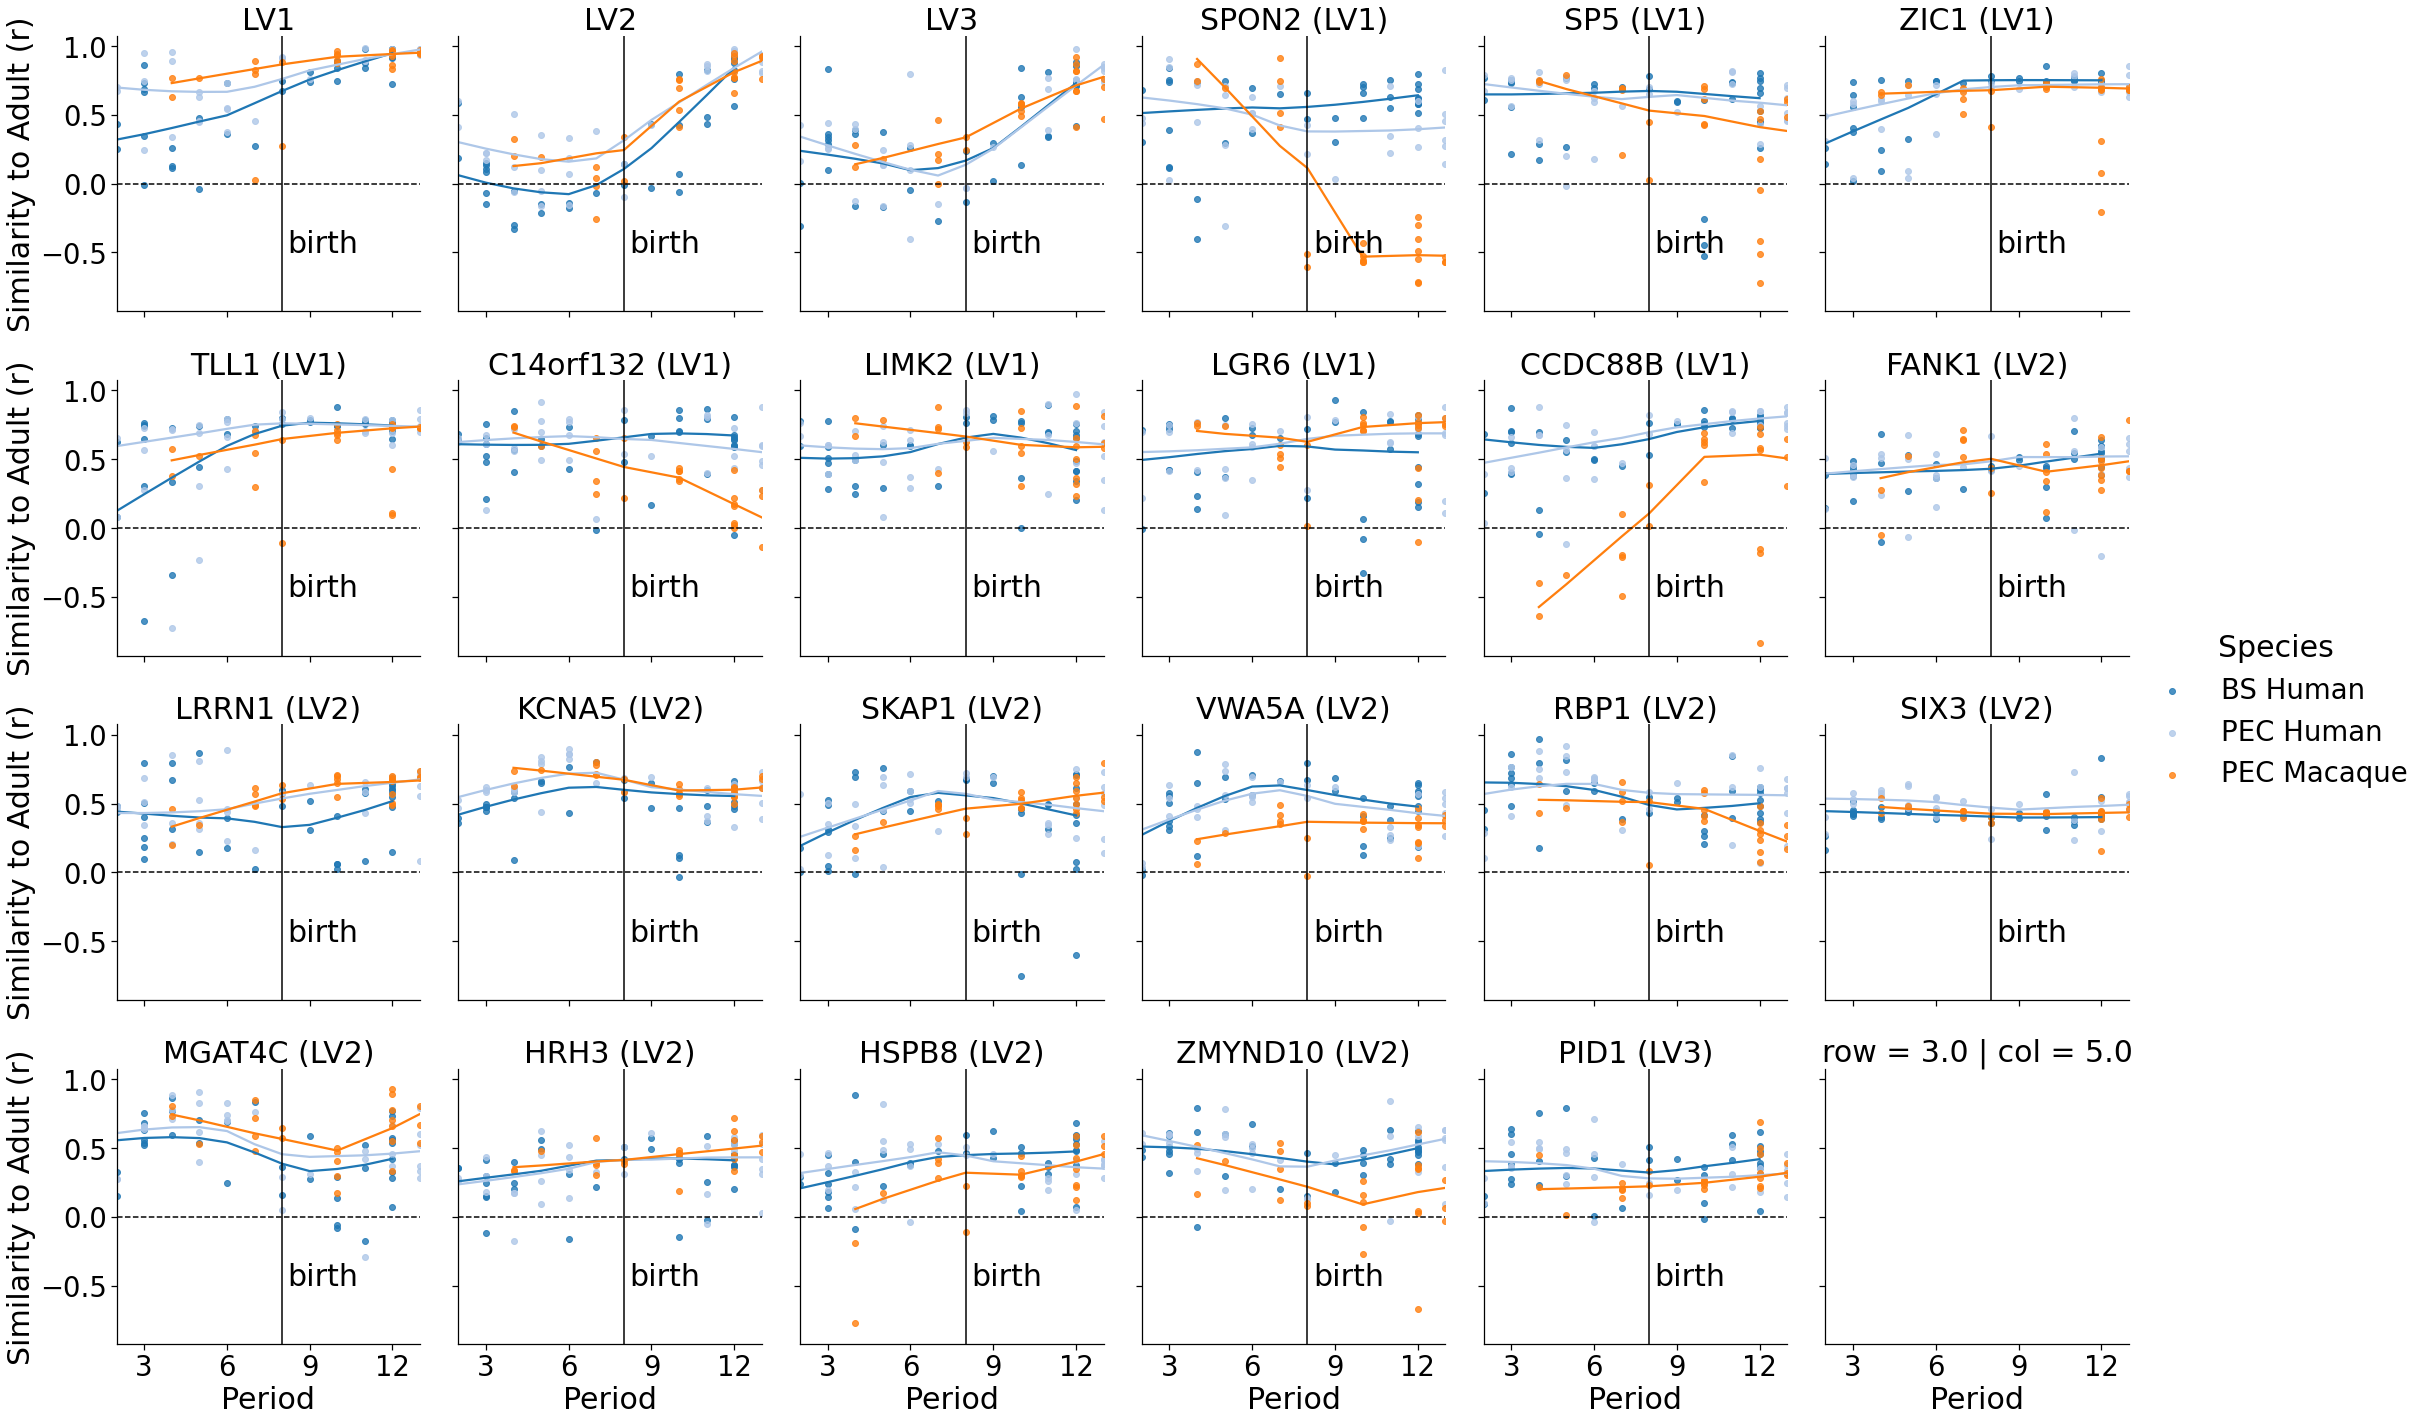

In [743]:
with sns.plotting_context('notebook',font_scale=2.5):
    g = sns.lmplot(x='Period',y='value',hue='Species',lowess=True,
                   hue_order=['BS Human','PEC Human','PEC Macaque'],
              row='row',col='col',data=combtall,sharey=True,sharex=True,
                   palette='tab20')
    axes = g.axes.flatten()
    for i in range(len(gcols)):
        gene = gcols[i].split('_')[0]
        lv = [x for x in repsets.keys() if gene in repsets[x]]
        if len(lv) == 0:
            axes[i].set_title(gene)
        else:
            axes[i].set_title('%s (LV%s)'%(gene,lv[0]))
        axes[i].axhline(0,ls='--',c='k')
        axes[i].axvline(8,c='k')
        axes[i].text(8.2,-0.5,'birth')
        axes[i].set_xticks([3,6,9,12])
        if i%6==0:
            axes[i].set_ylabel('Similarity to Adult (r)')
    plt.savefig(os.path.join(fig_dir,'GeneHomology_Facetgrid.pdf'),bbox_inches='tight')

AttributeError: 'numpy.ndarray' object has no attribute 'scatter'

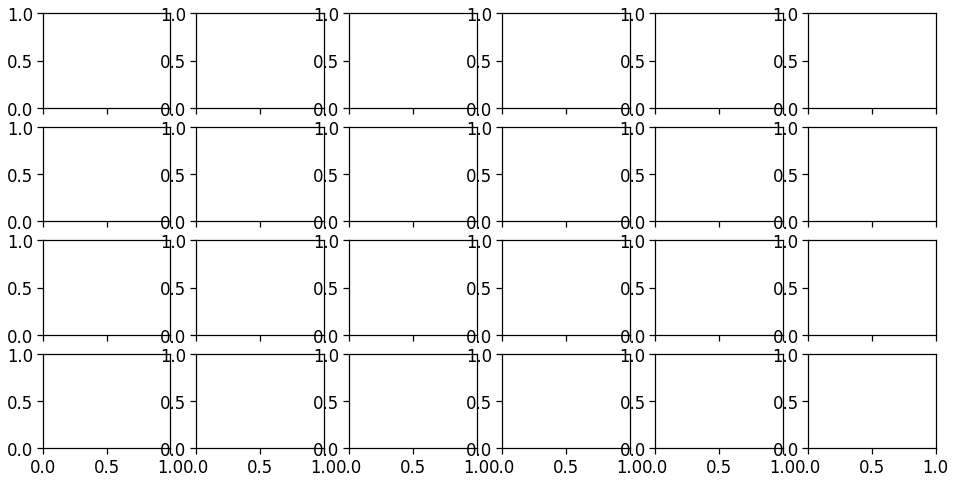

In [695]:
fig, axes = plt.subplots(4, 6, sharex=True, figsize=(16,8))
for i,col in enumerate([x for x in combined.columns if '_r' in x]):
    hue_regplot(ax=axes[i],x='Period',y=col,hue='Species',data=combined,lowess=True)
    axes[i].set_title(col.split('_'[0]))

C1_r


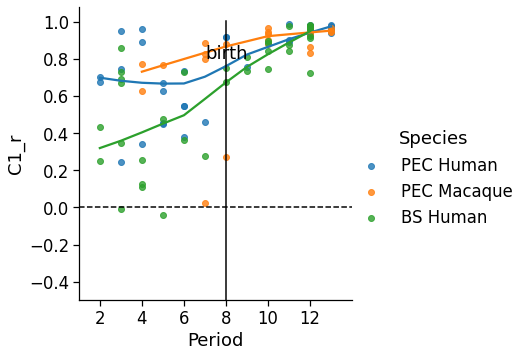

C2_r


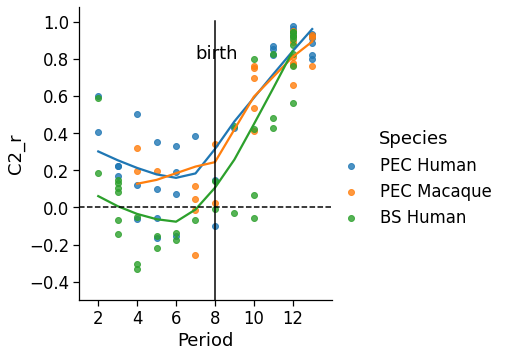

C3_r


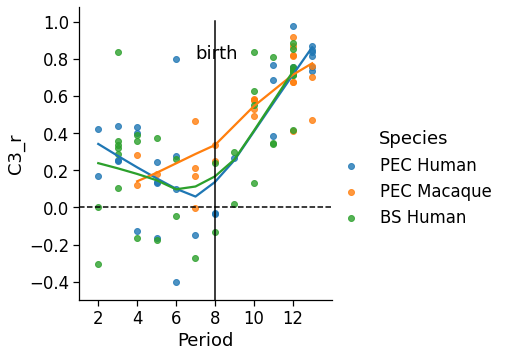

SPON2_r


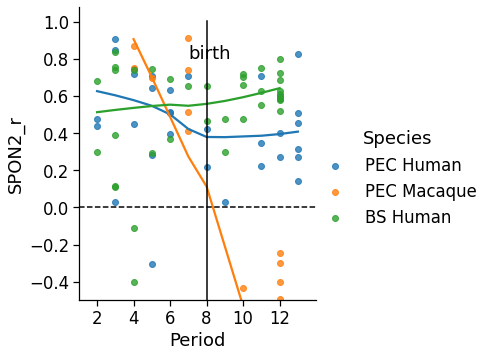

SP5_r


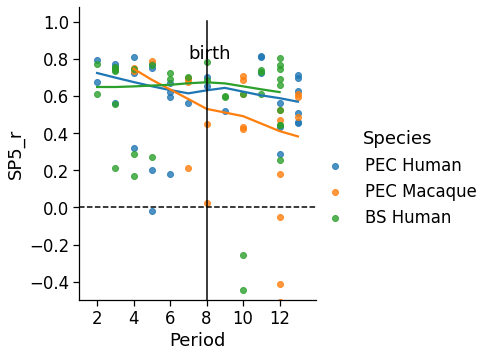

ZIC1_r


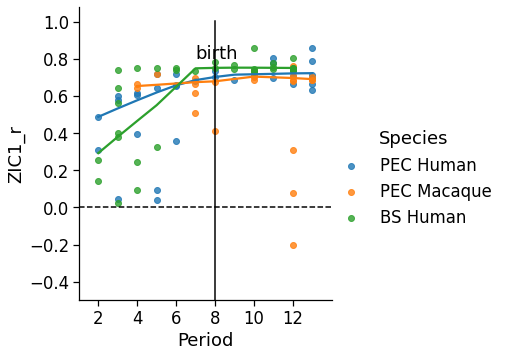

TLL1_r


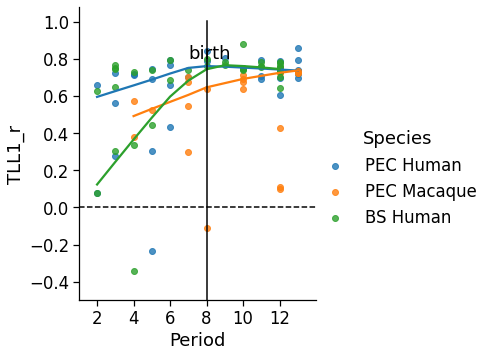

C14orf132_r


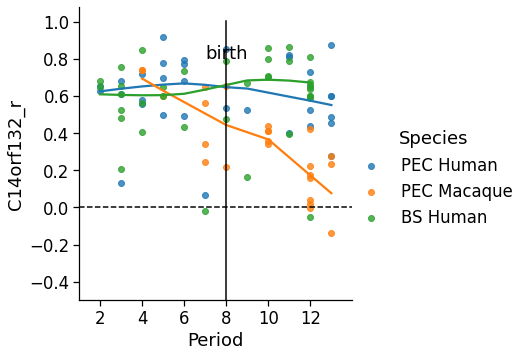

LIMK2_r


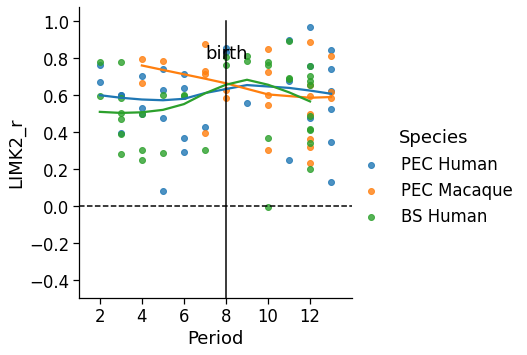

LGR6_r


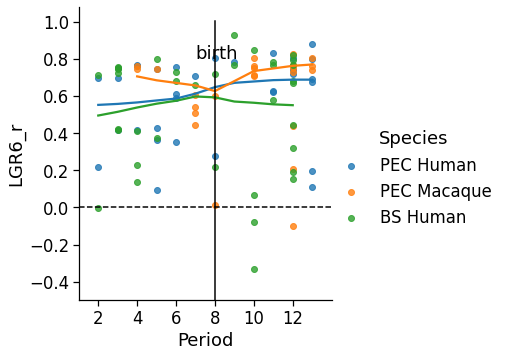

CCDC88B_r


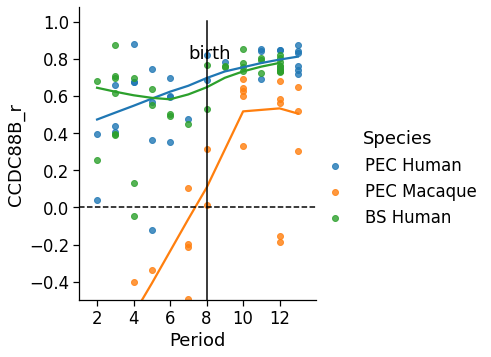

FANK1_r


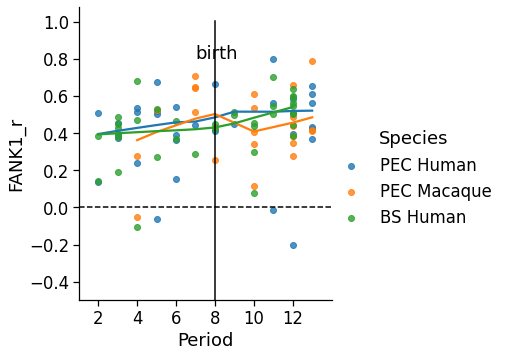

LRRN1_r


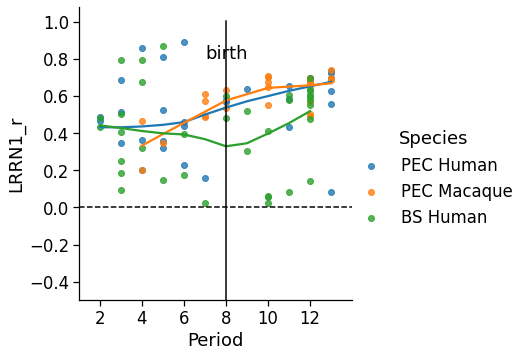

KCNA5_r


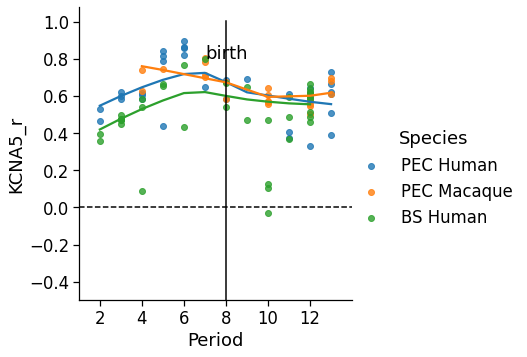

SKAP1_r


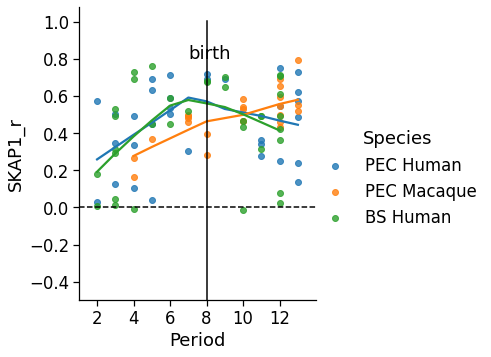

VWA5A_r


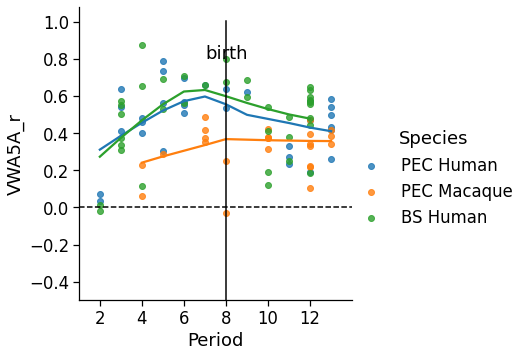

RBP1_r


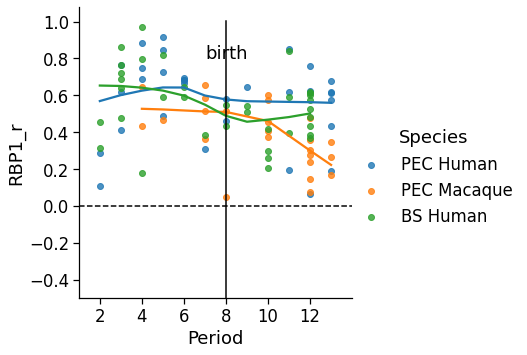

SIX3_r


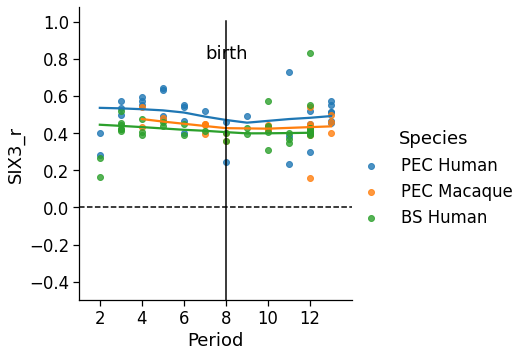

MGAT4C_r


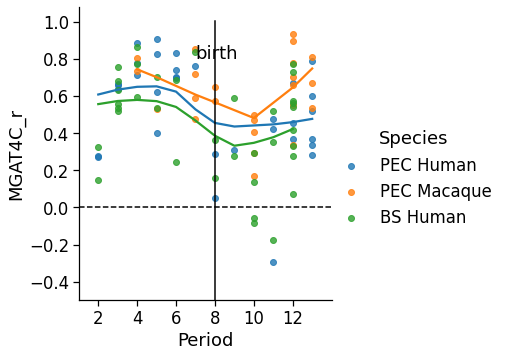

HRH3_r


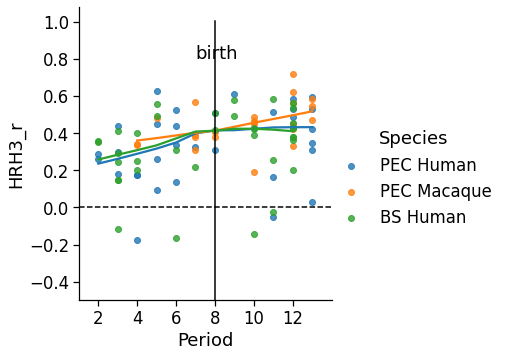

HSPB8_r


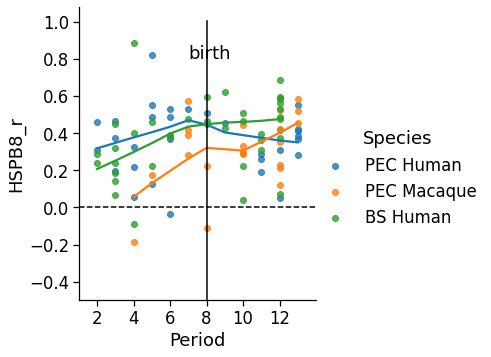

ZMYND10_r


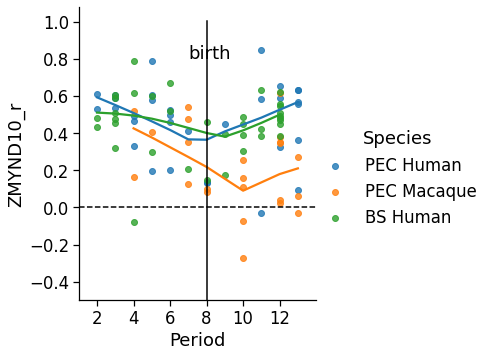

PID1_r


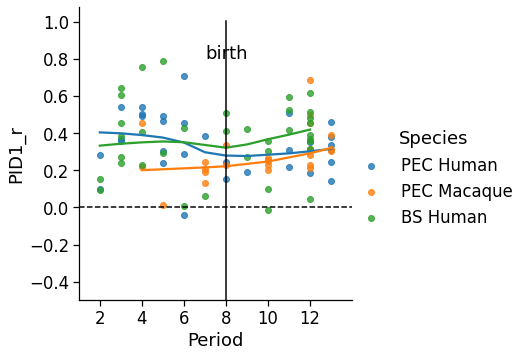

In [692]:
for col in [x for x in combined.columns if '_r' in x]:
    print(col)
    sns.lmplot(x='Period',y=col,hue='Species',data=combined,lowess=True)
    plt.ylim(-0.5,1.08)
    plt.xlim(1,14)
    plt.axhline(0,ls='--',c='k')
    plt.axvline(8,ymax=0.95,c='k')
    plt.text(7,0.8,'birth')
    plt.xticks([2,4,6,8,10,12])
    plt.show()

In [ ]:
[x for x in ]